In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/particulate_south.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   lucca
   2   viterbo
   3   brindisi
   4   rieti
   5   arezzo
   6   massa
   7   siena
   8   sassari
   9   carbonia
   10   ancona
   11   caltanissetta
   12   savona
   13   pisa
   14   taranto
   15   livorno
   16   chieti
   17   siracusa
   18   cosenza
   19   matera
   20   foggia
   21   imperia
   22   prato
   23   firenze
   24   roma
   25   genova
   26   frosinone
   27   trapani
   28   enna
   29   cagliari
   30   agrigento
   31   l_aquila
   32   crotone
   33   latina
   34   lecce
   35   benevento
   36   bat
   37   ragusa
   38   ascoli_piceno
   39   campobasso
   40   potenza
   41   catania
   42   avellino
   43   isernia
   44   reggio_di_calabria
   45   catanzaro
   46   fermo
   47   pistoia
   48   bari
   49   macerata
   50   la_spezia
   51   palermo
   52   messina
   53   nuoro
   54   terni
   55   caserta
   56   salerno
   57   pesaro
   58   grosseto
   59  

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 lucca
2 viterbo
3 brindisi
4 rieti
5 arezzo
6 massa
7 siena
8 sassari
9 ancona
10 caltanissetta
11 savona
12 pisa
13 taranto
14 livorno
15 chieti
16 siracusa
17 cosenza
18 matera
19 foggia
20 imperia
21 prato
22 firenze
23 roma
24 genova
25 frosinone
26 trapani
27 enna
28 cagliari
29 agrigento
30 l_aquila
31 crotone
32 latina
33 lecce
34 benevento
35 bat
36 ragusa
37 ascoli_piceno
38 campobasso
39 potenza
40 catania
41 avellino
42 reggio_di_calabria
43 catanzaro
44 fermo
45 pistoia
46 bari
47 macerata
48 la_spezia
49 palermo
50 messina
51 nuoro
52 terni
53 caserta
54 salerno
55 pesaro
56 grosseto
57 teramo
58 napoli
59 pescara
60 vibo_valentia
61 oristano
62 perugia


In [4]:
#add random feature
import random

featurestobeused += ",randomfeature"
features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

random.seed(1)
for i in range(len(ylogpropcasi)):
    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wno_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
population
    avg_wno_period1_2020
avg_wco_period1_2020
    avg_wnmvo

In [6]:
feats_innet_to_visualnamemap = {"density" : "Density",
                                "commutersdensity" : "Com. Density",                          
                                "depriv" : "Depriv. Index",
                                "lat" : "Latitude",
                                "Ratio0200ver65" : "Old Young Ratio",
                                "avg_wpm10_period1_2020" : "Avg. PM10",
                                "avg_wno_period1_2020" : "Avg. NO",
                                "avg_wpans_period1_2020" : "Avg. PANS",
                                "avg_wso2_period1_2020" : "Avg. SO2",
                                "randomfeature" : "Random Feat."}

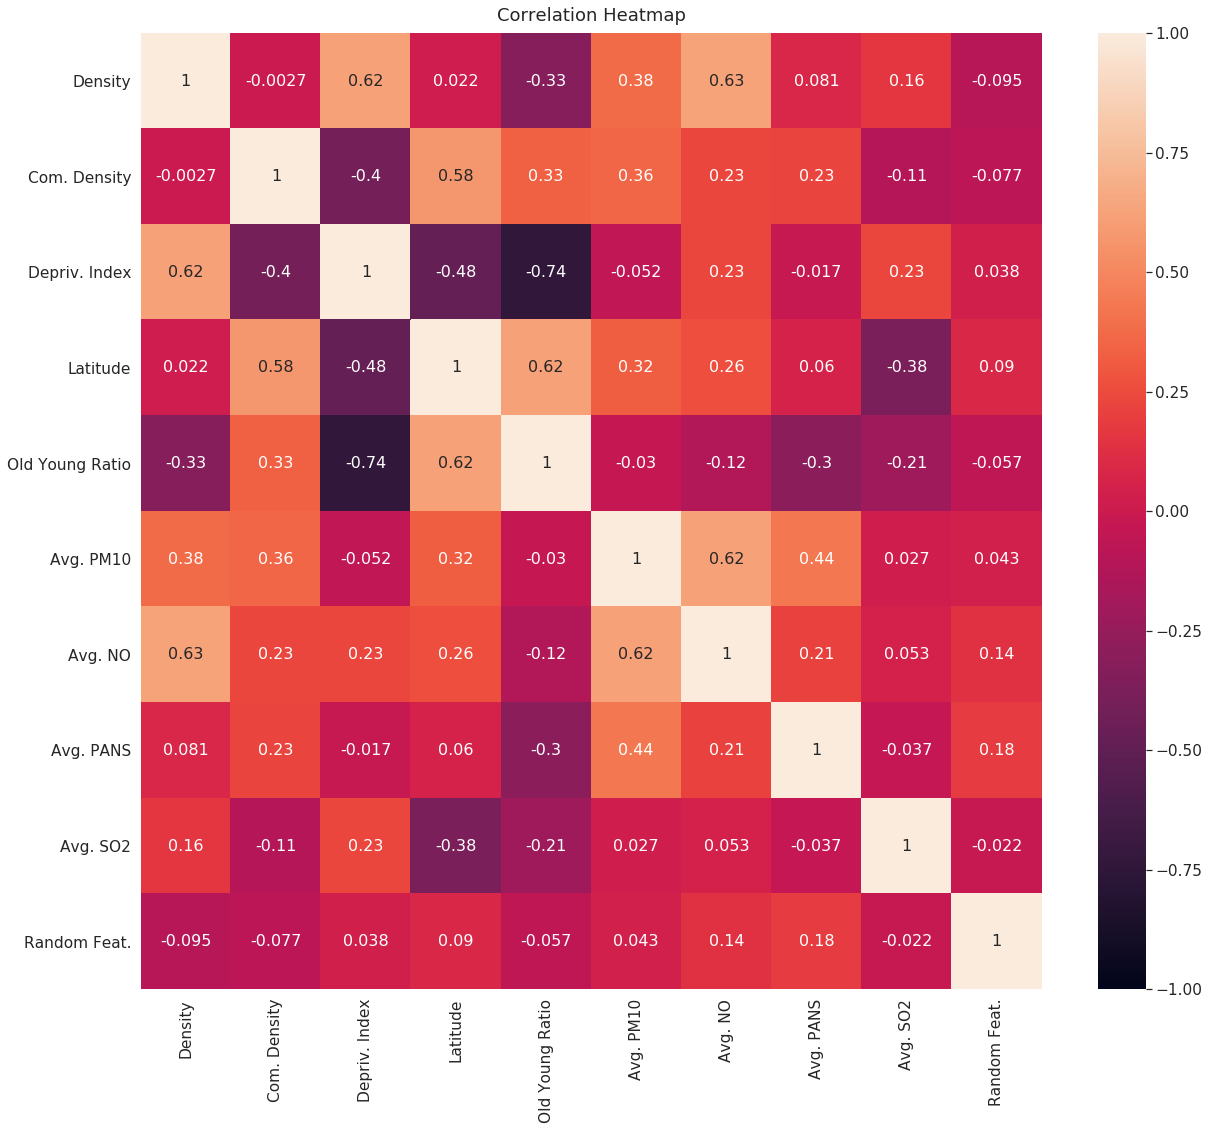

In [7]:
import seaborn as sns

featuresused = features

evaluatecorrelation = {}

for v in featuresused:
    vname = feats_innet_to_visualnamemap[v]
    evaluatecorrelation[vname] = features_dict[v]

plt.figure(figsize=(18, 16))
features_df = pd.DataFrame.from_dict(evaluatecorrelation)

sns.set(font_scale=1.4)
heatmap = sns.heatmap(features_df.corr(),vmin=-1, vmax=1, annot=True , annot_kws={"size": 16});
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

figure = heatmap.get_figure()    
figure.subplots_adjust()
figure.tight_layout()
figure.savefig('heatmap.png',  bbox_inches="tight", pad_inches=0.5)


Grid Search to optimize the RMSE on the Full Set

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.32277  0.04200 
    Test set average RMSE:  0.88040  0.10011 

Prediction STD :    0.94511
True value STD :    1.15017
Difference in percentage:   17.82908

             Fullset RMSE:    0.31290
                       R2:    0.92599


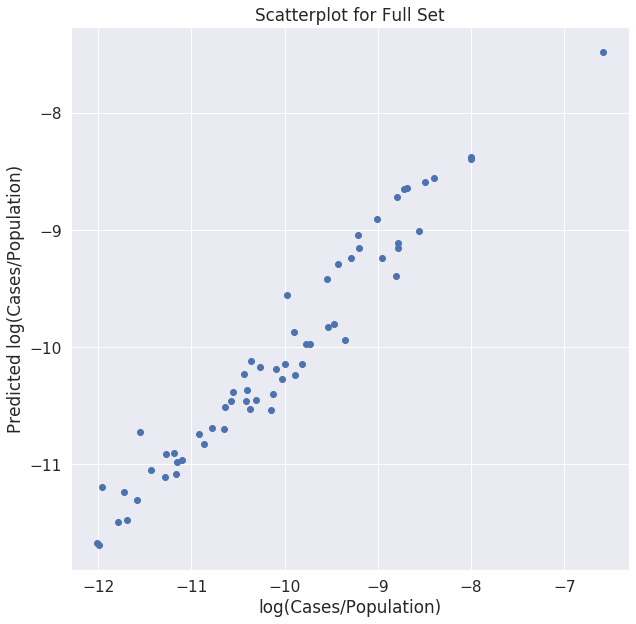

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.16335 +/- 0.03048
Feature:                  Depriv. Index, Score: 0.09767 +/- 0.01582
Feature:                       Latitude, Score: 0.48614 +/- 0.06897
Feature:                Old Young Ratio, Score: 0.08847 +/- 0.00935
Feature:                        Avg. NO, Score: 0.10868 +/- 0.01556


<Figure size 432x288 with 0 Axes>

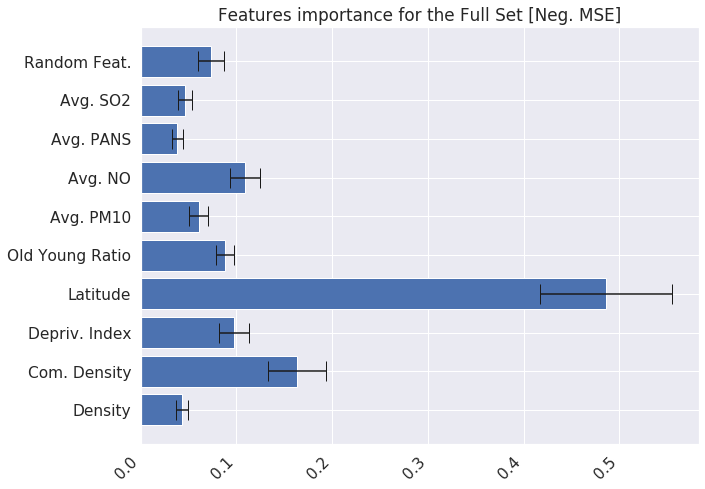

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                   Com. Density, Score: 0.12348 +/- 0.02304
Feature:                  Depriv. Index, Score: 0.07383 +/- 0.01196
Feature:                       Latitude, Score: 0.36748 +/- 0.05213
Feature:                Old Young Ratio, Score: 0.06688 +/- 0.00707
Feature:                        Avg. NO, Score: 0.08215 +/- 0.01176


<Figure size 432x288 with 0 Axes>

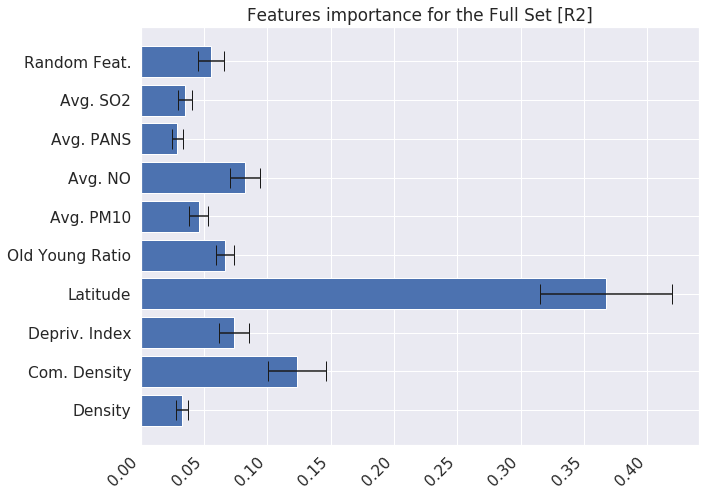

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.37115
                       R2:    0.90818


<Figure size 432x288 with 0 Axes>

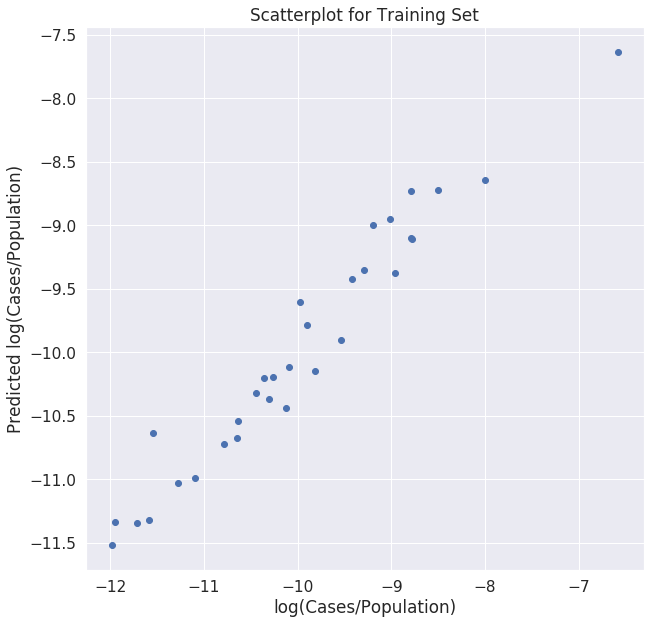

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.75821
                       R2:    0.49301


<Figure size 432x288 with 0 Axes>

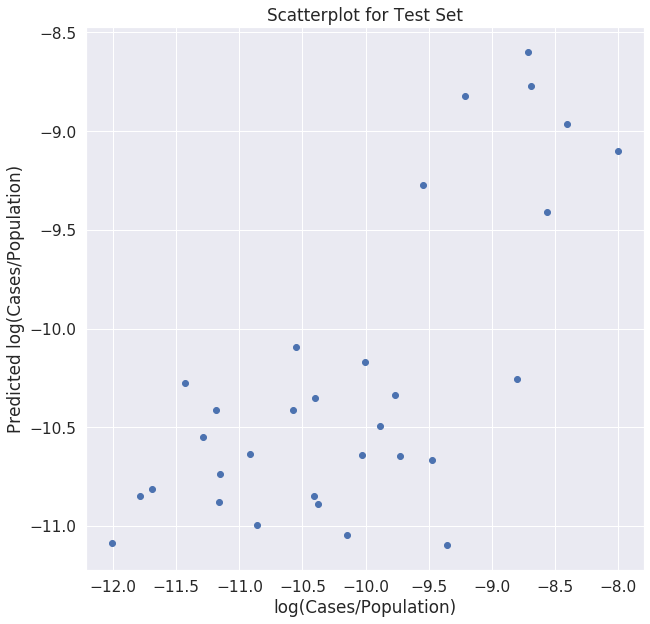

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.07395 +/- 0.04212
Feature:                  Depriv. Index, Score: 0.01380 +/- 0.01944
Feature:                       Latitude, Score: 0.41698 +/- 0.13102
Feature:                Old Young Ratio, Score: 0.00221 +/- 0.01333
Feature:                        Avg. NO, Score: 0.04863 +/- 0.04735


<Figure size 432x288 with 0 Axes>

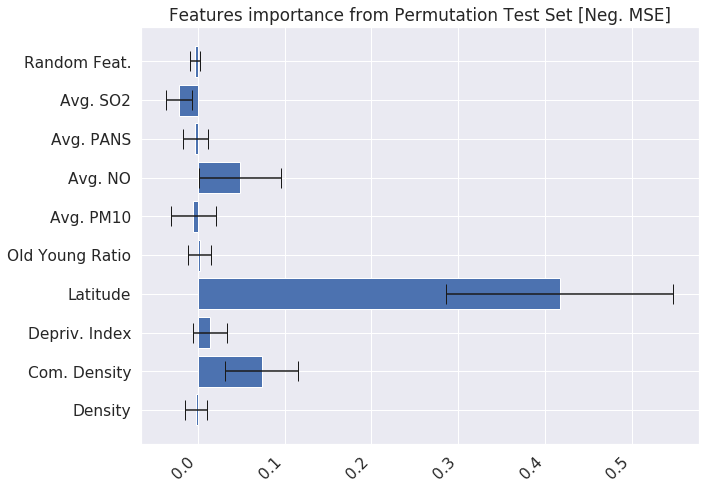

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.06522 +/- 0.03714
Feature:                  Depriv. Index, Score: 0.01217 +/- 0.01714
Feature:                       Latitude, Score: 0.36774 +/- 0.11554
Feature:                Old Young Ratio, Score: 0.00195 +/- 0.01175
Feature:                        Avg. NO, Score: 0.04289 +/- 0.04175


<Figure size 432x288 with 0 Axes>

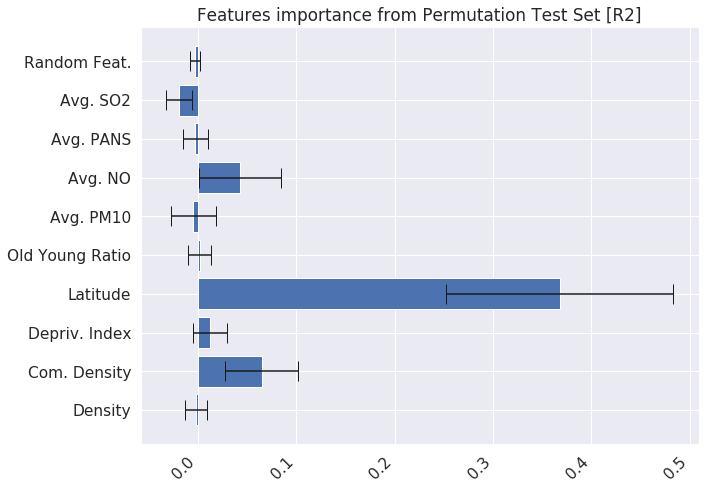

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.04202 +/- 0.00686
Feature:                   Com. Density, Score: 0.14723 +/- 0.03553
Feature:                  Depriv. Index, Score: 0.10994 +/- 0.02221
Feature:                       Latitude, Score: 0.54569 +/- 0.10752
Feature:                Old Young Ratio, Score: 0.05267 +/- 0.00916
Feature:                      Avg. PM10, Score: 0.09284 +/- 0.02446
Feature:                        Avg. NO, Score: 0.14213 +/- 0.03465
Feature:                      Avg. PANS, Score: 0.04816 +/- 0.00928
Feature:                       Avg. SO2, Score: 0.05957 +/- 0.01693


<Figure size 432x288 with 0 Axes>

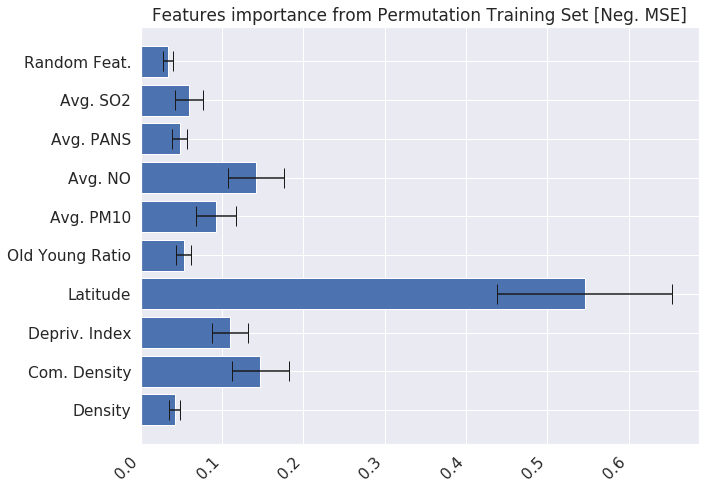

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.02800 +/- 0.00457
Feature:                   Com. Density, Score: 0.09813 +/- 0.02368
Feature:                  Depriv. Index, Score: 0.07328 +/- 0.01480
Feature:                       Latitude, Score: 0.36371 +/- 0.07166
Feature:                Old Young Ratio, Score: 0.03511 +/- 0.00611
Feature:                      Avg. PM10, Score: 0.06188 +/- 0.01630
Feature:                        Avg. NO, Score: 0.09473 +/- 0.02310
Feature:                      Avg. PANS, Score: 0.03210 +/- 0.00618
Feature:                       Avg. SO2, Score: 0.03970 +/- 0.01129


<Figure size 432x288 with 0 Axes>

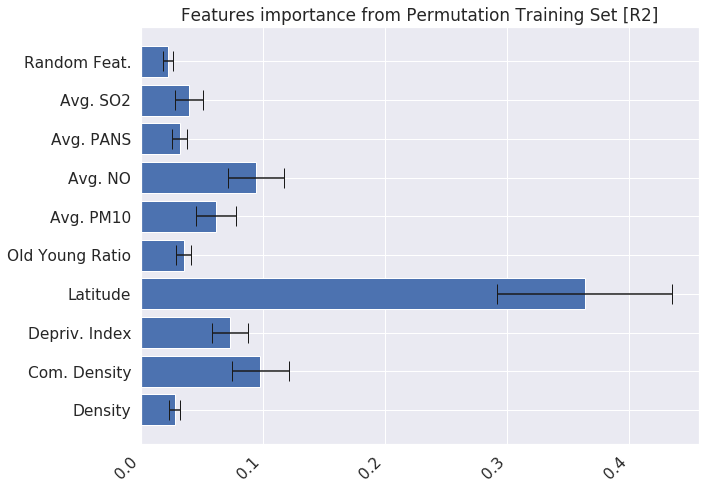

<Figure size 720x720 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.35463  0.03977 
    Test set average RMSE:  0.93997  0.11513 

Prediction STD :    0.90271
True value STD :    1.15017
Difference in percentage:   21.51473

             Fullset RMSE:    0.34527
                       R2:    0.90989


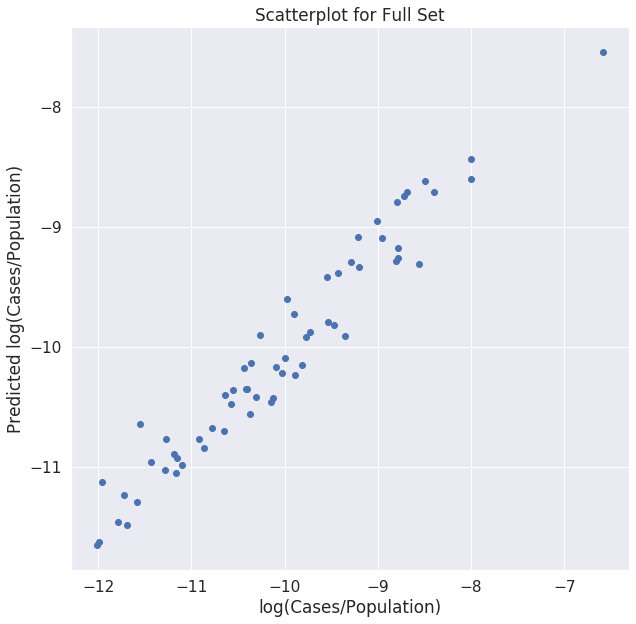

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.33012 +/- 0.05932
Feature:                  Depriv. Index, Score: 0.20853 +/- 0.03677
Feature:                Old Young Ratio, Score: 0.16295 +/- 0.02001
Feature:                      Avg. PM10, Score: 0.10540 +/- 0.01892
Feature:                        Avg. NO, Score: 0.19340 +/- 0.02982
Feature:                       Avg. SO2, Score: 0.08000 +/- 0.01554


<Figure size 432x288 with 0 Axes>

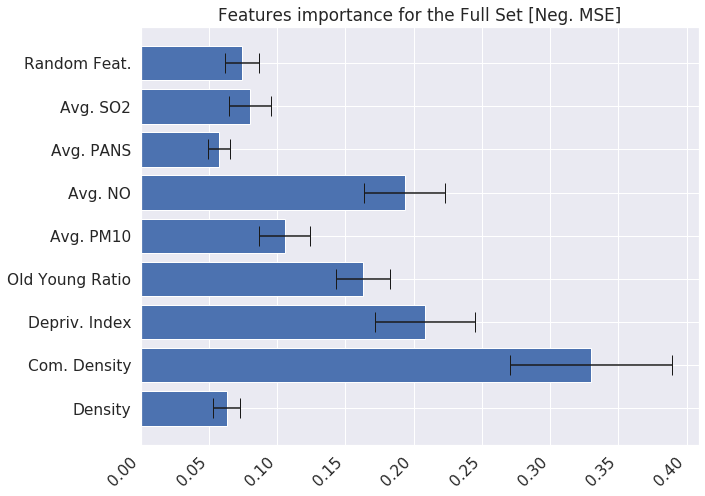

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                   Com. Density, Score: 0.24954 +/- 0.04484
Feature:                  Depriv. Index, Score: 0.15763 +/- 0.02779
Feature:                Old Young Ratio, Score: 0.12317 +/- 0.01512
Feature:                      Avg. PM10, Score: 0.07968 +/- 0.01430
Feature:                        Avg. NO, Score: 0.14620 +/- 0.02254
Feature:                       Avg. SO2, Score: 0.06047 +/- 0.01175


<Figure size 432x288 with 0 Axes>

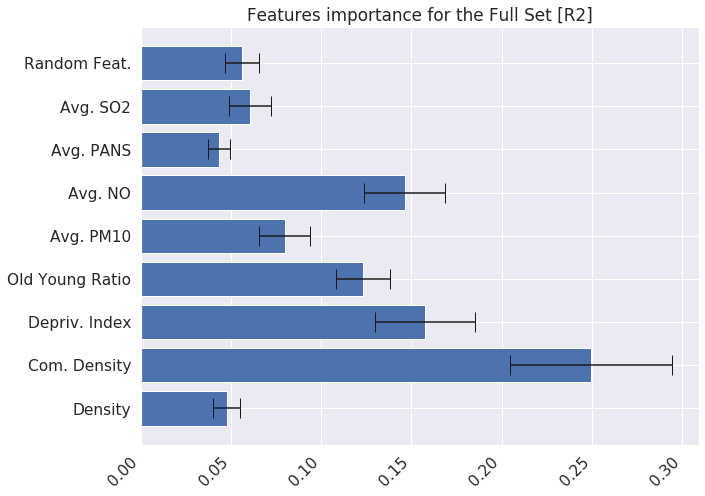

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.41640
                       R2:    0.89047


<Figure size 432x288 with 0 Axes>

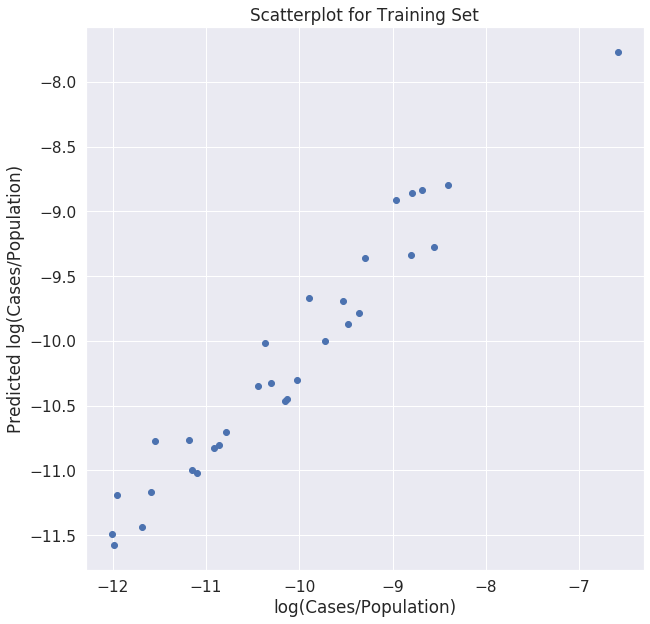

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.75144
                       R2:    0.46210


<Figure size 432x288 with 0 Axes>

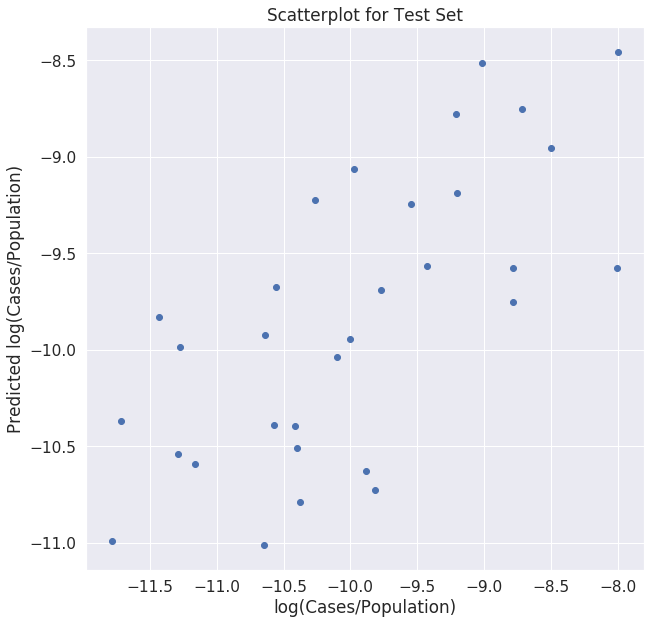

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.22737 +/- 0.09012
Feature:                  Depriv. Index, Score: 0.07161 +/- 0.04439
Feature:                Old Young Ratio, Score: 0.06366 +/- 0.04028
Feature:                        Avg. NO, Score: 0.14190 +/- 0.08181


<Figure size 432x288 with 0 Axes>

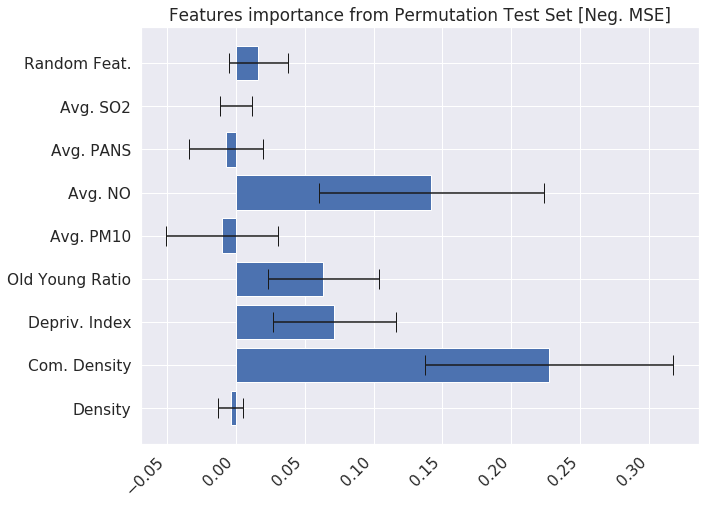

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.21660 +/- 0.08585
Feature:                  Depriv. Index, Score: 0.06821 +/- 0.04229
Feature:                Old Young Ratio, Score: 0.06065 +/- 0.03837
Feature:                        Avg. NO, Score: 0.13518 +/- 0.07793


<Figure size 432x288 with 0 Axes>

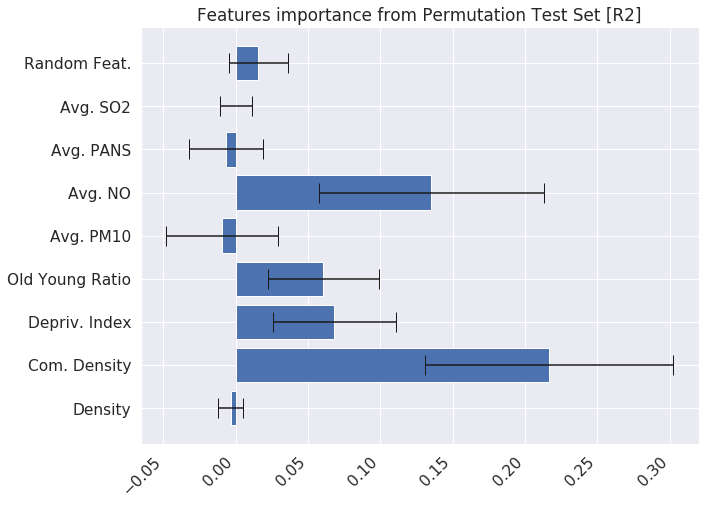

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.20154 +/- 0.03370
Feature:                  Depriv. Index, Score: 0.14647 +/- 0.02545
Feature:                Old Young Ratio, Score: 0.21555 +/- 0.04195
Feature:                      Avg. PM10, Score: 0.12436 +/- 0.02627
Feature:                        Avg. NO, Score: 0.39665 +/- 0.09967


<Figure size 432x288 with 0 Axes>

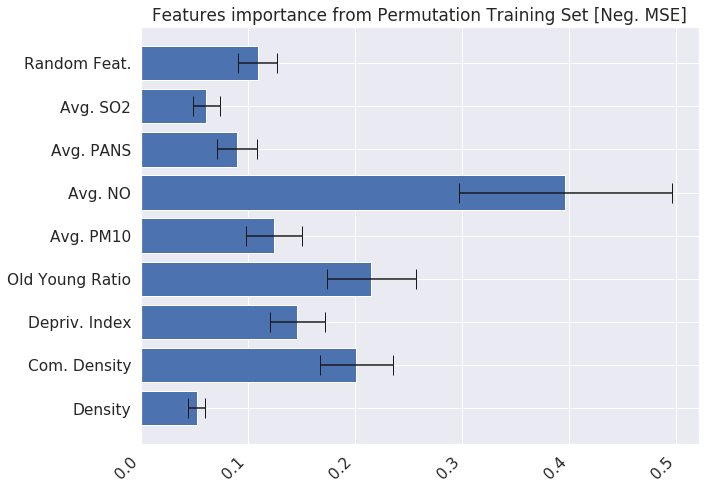

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                   Com. Density, Score: 0.12731 +/- 0.02129
Feature:                  Depriv. Index, Score: 0.09252 +/- 0.01608
Feature:                Old Young Ratio, Score: 0.13616 +/- 0.02650
Feature:                      Avg. PM10, Score: 0.07856 +/- 0.01659
Feature:                        Avg. NO, Score: 0.25056 +/- 0.06296


<Figure size 432x288 with 0 Axes>

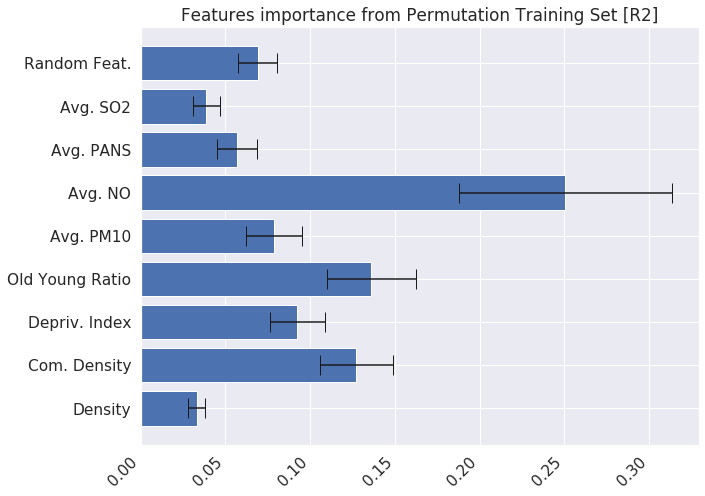

<Figure size 720x720 with 0 Axes>

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_fullset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.36024  0.04303 
    Test set average RMSE:  1.01477  0.12401 

Prediction STD :    0.87777
True value STD :    1.15017
Difference in percentage:   23.68361

             Fullset RMSE:    0.35225
                       R2:    0.90620


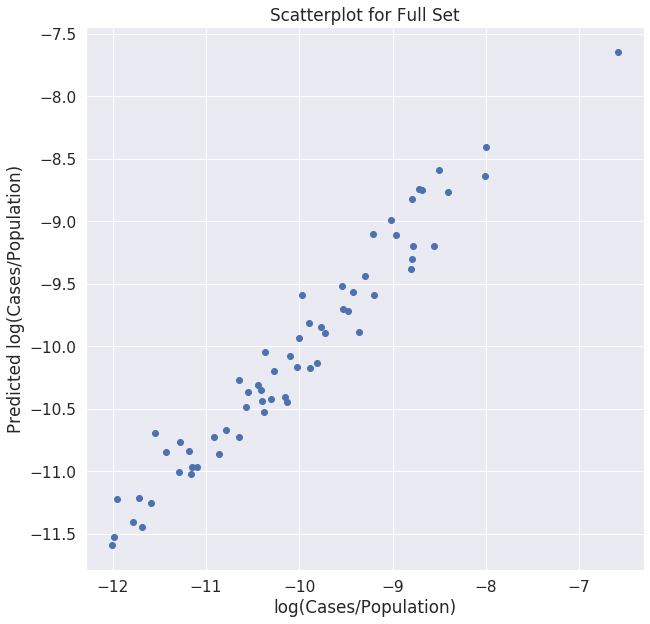

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.10085 +/- 0.01342
Feature:                  Depriv. Index, Score: 0.31610 +/- 0.05842
Feature:                Old Young Ratio, Score: 0.25957 +/- 0.03104
Feature:                      Avg. PM10, Score: 0.15426 +/- 0.02791
Feature:                        Avg. NO, Score: 0.25454 +/- 0.03772
Feature:                       Avg. SO2, Score: 0.10035 +/- 0.01610


<Figure size 432x288 with 0 Axes>

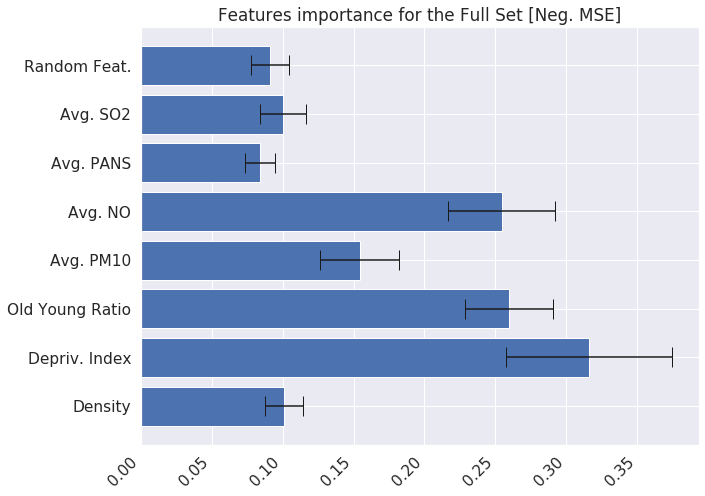

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.07623 +/- 0.01015
Feature:                  Depriv. Index, Score: 0.23895 +/- 0.04416
Feature:                Old Young Ratio, Score: 0.19622 +/- 0.02346
Feature:                      Avg. PM10, Score: 0.11661 +/- 0.02109
Feature:                        Avg. NO, Score: 0.19242 +/- 0.02852
Feature:                       Avg. SO2, Score: 0.07585 +/- 0.01217


<Figure size 432x288 with 0 Axes>

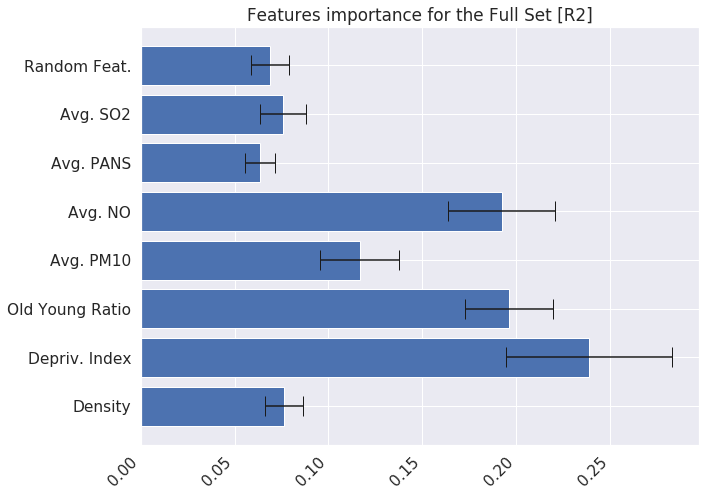

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.40007
                       R2:    0.89449


<Figure size 432x288 with 0 Axes>

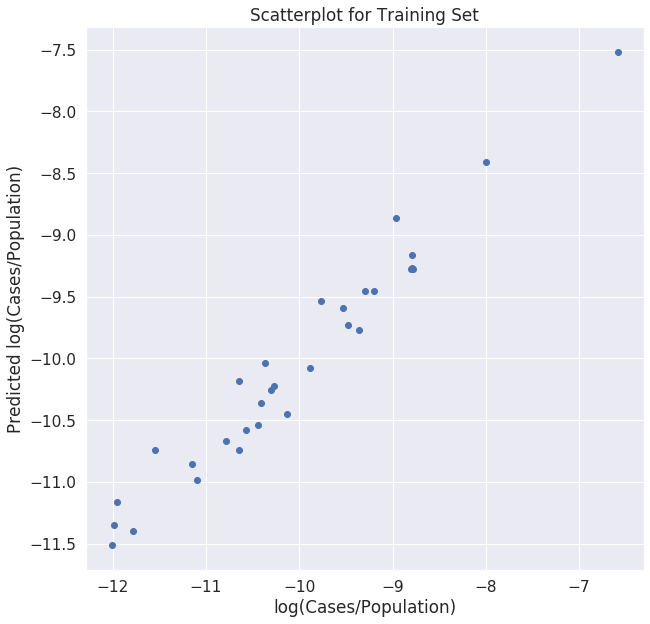

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.99354
                       R2:    0.12516


<Figure size 432x288 with 0 Axes>

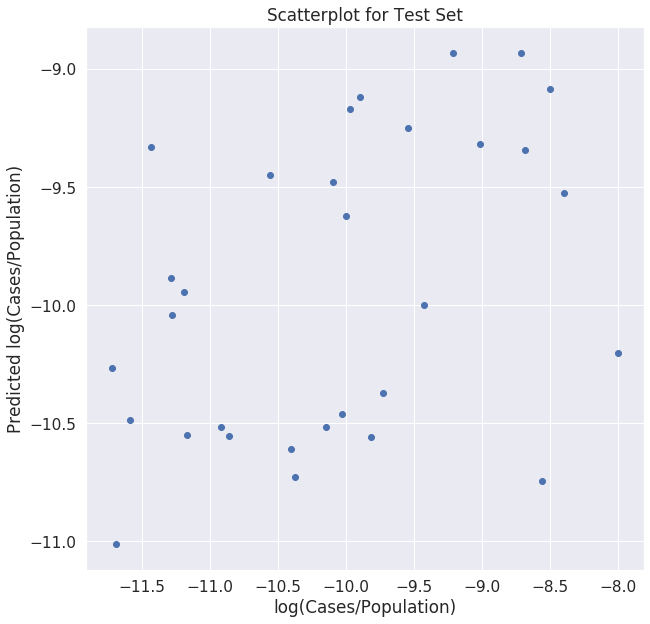

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.12135 +/- 0.06593
Feature:                Old Young Ratio, Score: 0.08649 +/- 0.03848
Feature:                        Avg. NO, Score: 0.06046 +/- 0.09579
Feature:                       Avg. SO2, Score: 0.01193 +/- 0.02001


<Figure size 432x288 with 0 Axes>

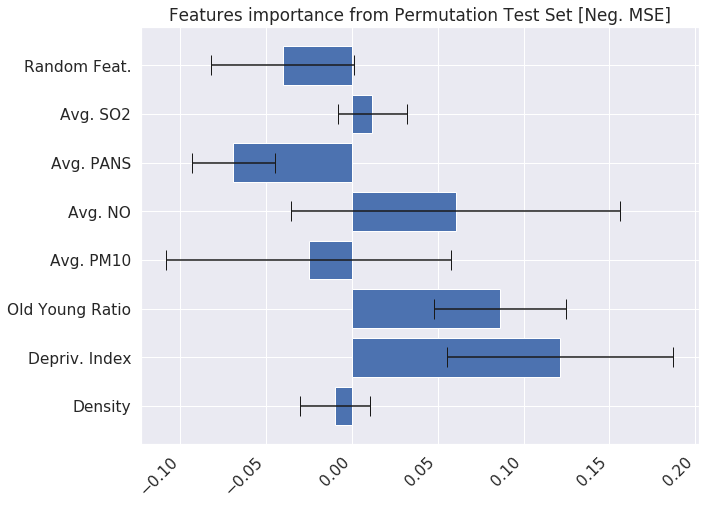

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.10755 +/- 0.05843
Feature:                Old Young Ratio, Score: 0.07666 +/- 0.03410
Feature:                        Avg. NO, Score: 0.05358 +/- 0.08489
Feature:                       Avg. SO2, Score: 0.01058 +/- 0.01773


<Figure size 432x288 with 0 Axes>

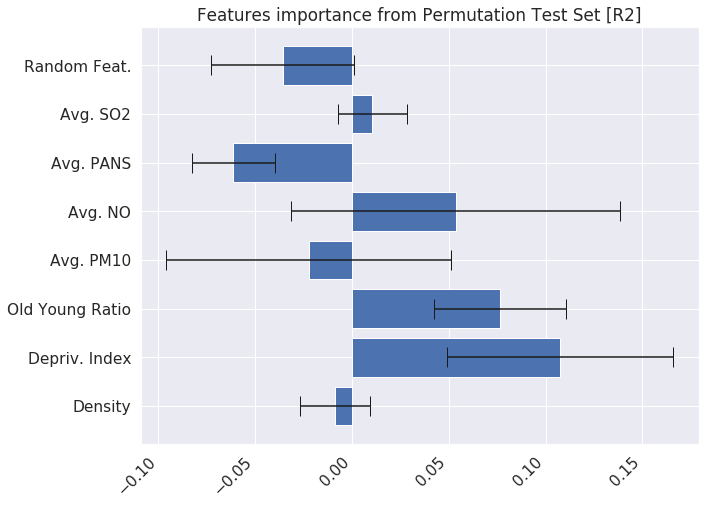

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.24783 +/- 0.05698
Feature:                      Avg. PM10, Score: 0.25780 +/- 0.06785
Feature:                        Avg. NO, Score: 0.27516 +/- 0.07262


<Figure size 432x288 with 0 Axes>

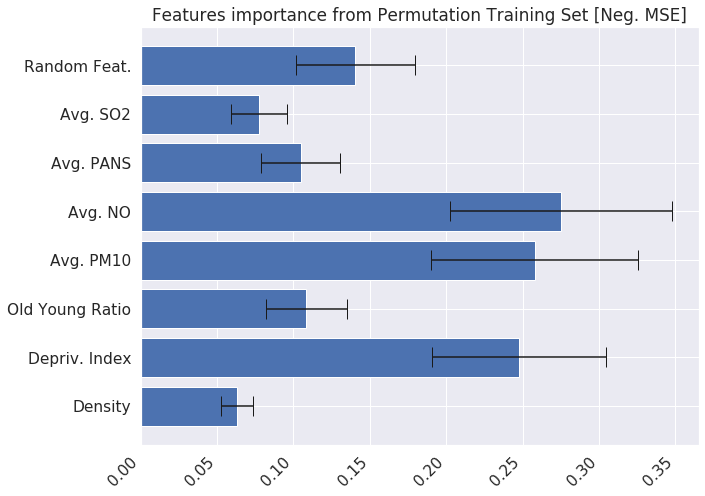

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                  Depriv. Index, Score: 0.16336 +/- 0.03756
Feature:                      Avg. PM10, Score: 0.16993 +/- 0.04473
Feature:                        Avg. NO, Score: 0.18138 +/- 0.04787


<Figure size 432x288 with 0 Axes>

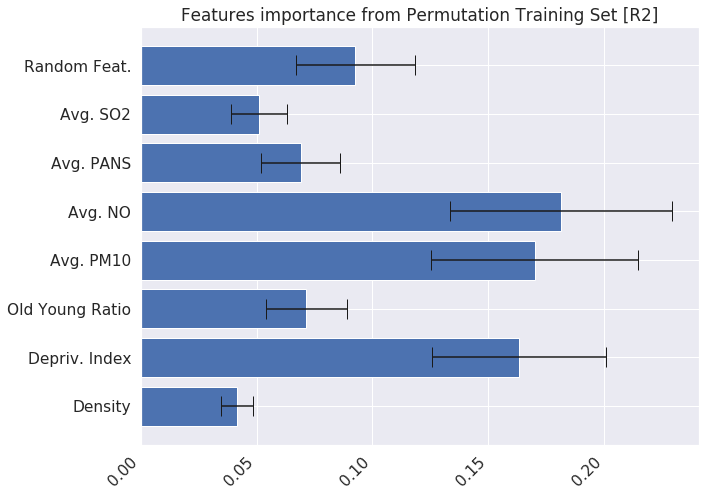

<Figure size 720x720 with 0 Axes>

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse  = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Training Set

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.32077  0.04360 
    Test set average RMSE:  0.88362  0.09370 

Prediction STD :    0.98915
True value STD :    1.15017
Difference in percentage:   14.00001

             Fullset RMSE:    0.33103
                       R2:    0.91717


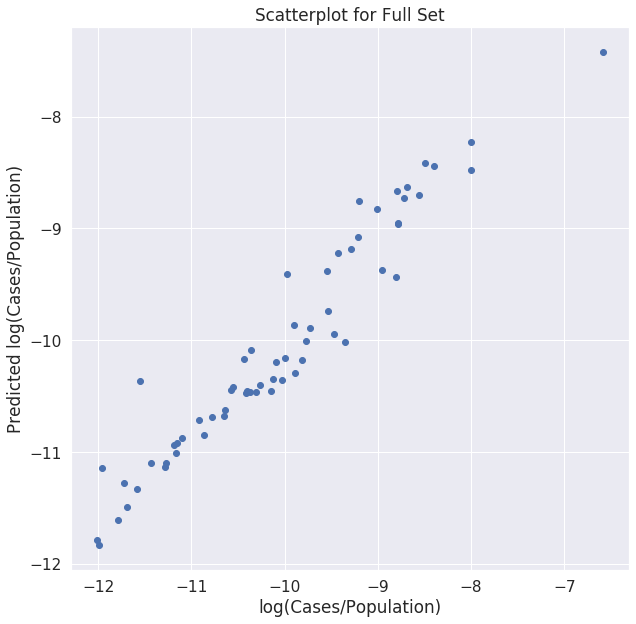

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                       Latitude, Score: 1.65138 +/- 0.24650


<Figure size 432x288 with 0 Axes>

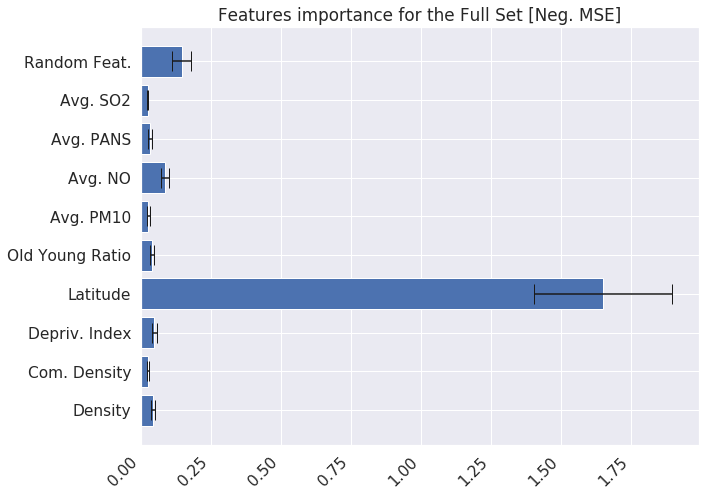

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                       Latitude, Score: 1.24831 +/- 0.18633


<Figure size 432x288 with 0 Axes>

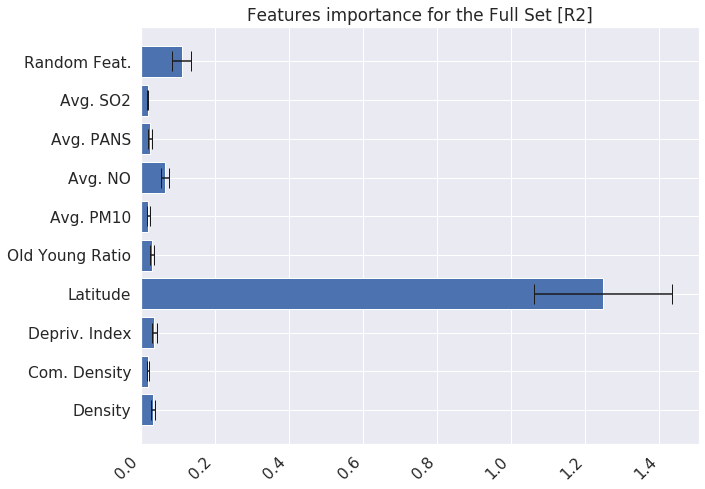

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.35149
                       R2:    0.91866


<Figure size 432x288 with 0 Axes>

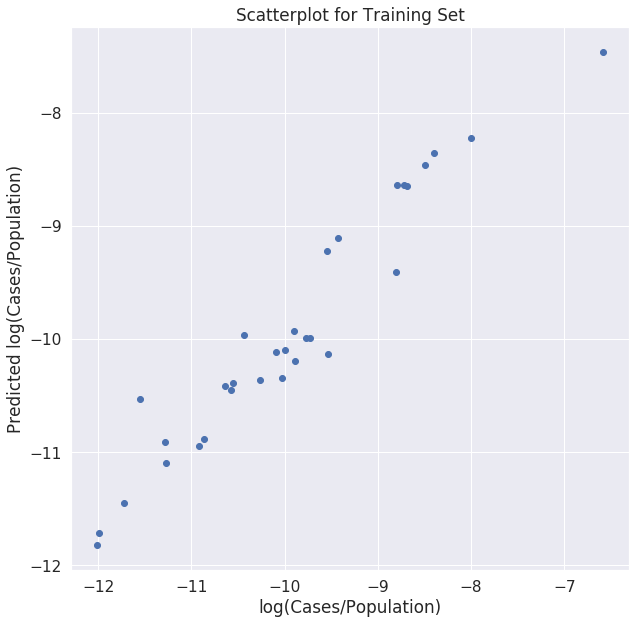

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.84274
                       R2:    0.35703


<Figure size 432x288 with 0 Axes>

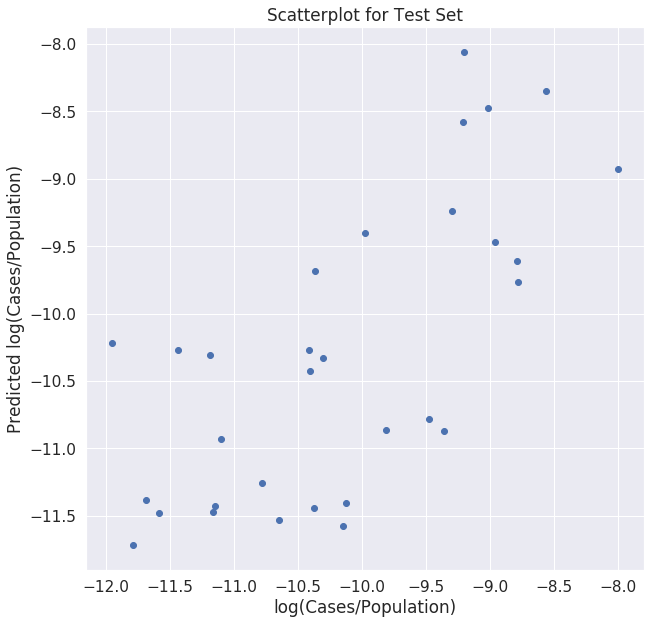

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.01571 +/- 0.02276
Feature:                       Latitude, Score: 0.94072 +/- 0.33225
Feature:                       Avg. SO2, Score: 0.02607 +/- 0.02001


<Figure size 432x288 with 0 Axes>

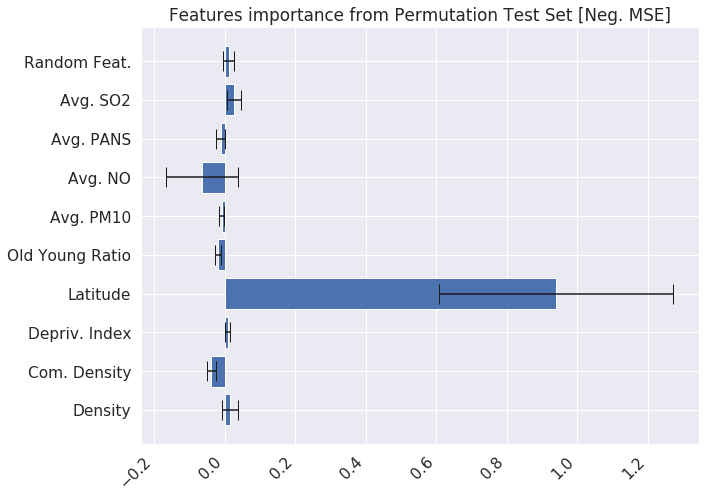

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.01422 +/- 0.02060
Feature:                       Latitude, Score: 0.85166 +/- 0.30080
Feature:                       Avg. SO2, Score: 0.02361 +/- 0.01812


<Figure size 432x288 with 0 Axes>

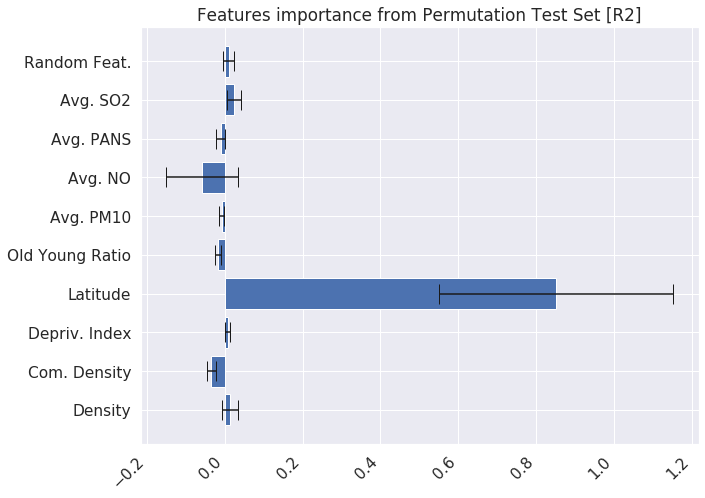

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.05014 +/- 0.01241
Feature:                   Com. Density, Score: 0.03963 +/- 0.00818
Feature:                       Latitude, Score: 1.75752 +/- 0.47513
Feature:                        Avg. NO, Score: 0.26083 +/- 0.06224
Feature:                       Avg. SO2, Score: 0.02910 +/- 0.00830


<Figure size 432x288 with 0 Axes>

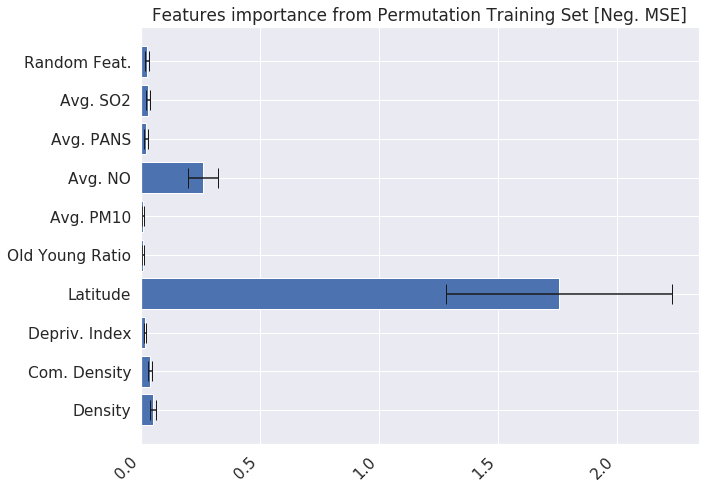

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.03301 +/- 0.00817
Feature:                   Com. Density, Score: 0.02609 +/- 0.00539
Feature:                       Latitude, Score: 1.15719 +/- 0.31283
Feature:                        Avg. NO, Score: 0.17173 +/- 0.04098
Feature:                       Avg. SO2, Score: 0.01916 +/- 0.00546


<Figure size 432x288 with 0 Axes>

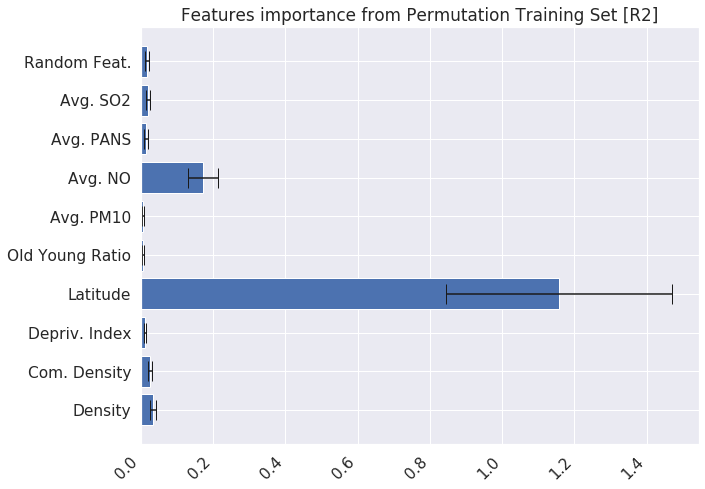

<Figure size 720x720 with 0 Axes>

In [11]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.36179  0.04824 
    Test set average RMSE:  0.98366  0.11333 

Prediction STD :    0.92606
True value STD :    1.15017
Difference in percentage:   19.48512

             Fullset RMSE:    0.36865
                       R2:    0.89727


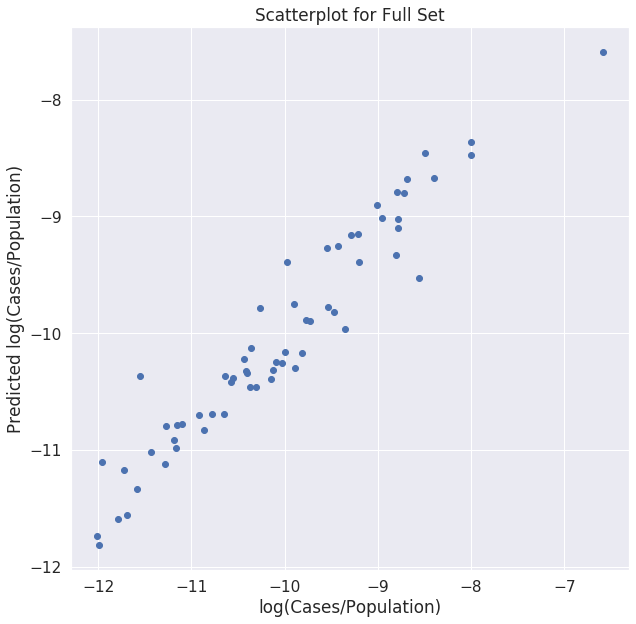

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.60645 +/- 0.11666
Feature:                  Depriv. Index, Score: 0.18552 +/- 0.04100
Feature:                Old Young Ratio, Score: 0.15053 +/- 0.02267
Feature:                        Avg. NO, Score: 0.15122 +/- 0.02542


<Figure size 432x288 with 0 Axes>

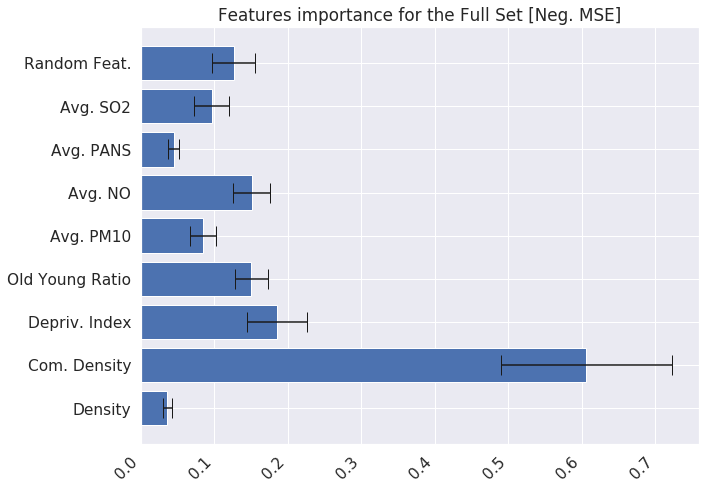

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                   Com. Density, Score: 0.45843 +/- 0.08818
Feature:                  Depriv. Index, Score: 0.14024 +/- 0.03099
Feature:                Old Young Ratio, Score: 0.11379 +/- 0.01714
Feature:                        Avg. NO, Score: 0.11431 +/- 0.01921


<Figure size 432x288 with 0 Axes>

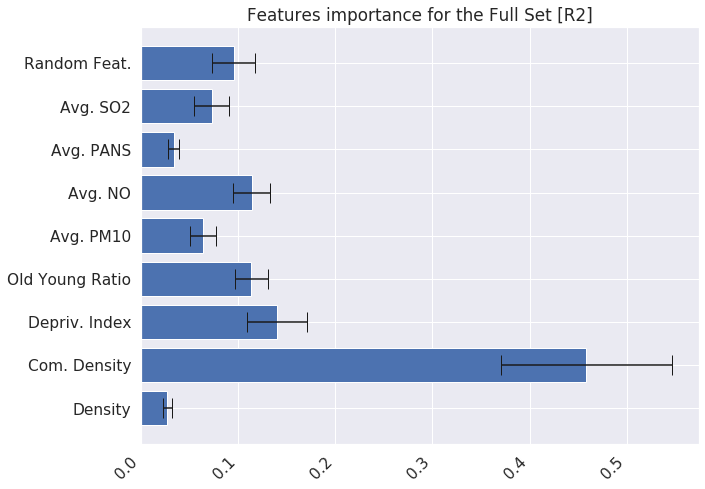

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.33540
                       R2:    0.89621


<Figure size 432x288 with 0 Axes>

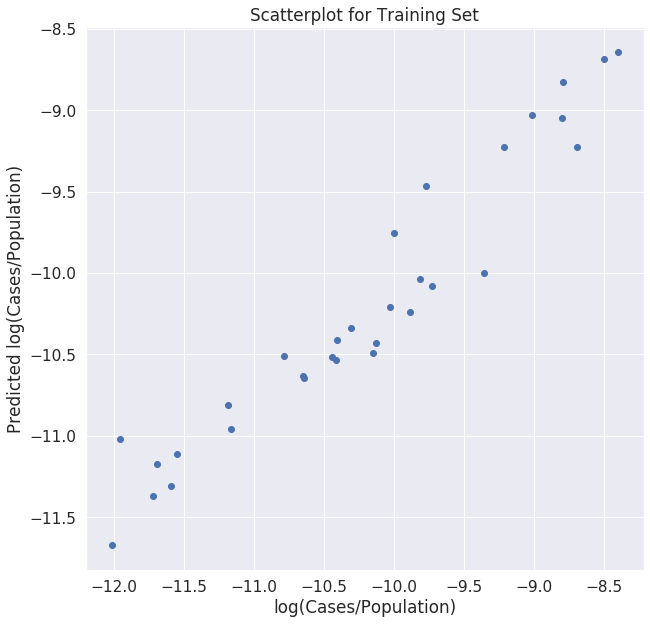

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.43084
                       R2:   -0.35592


<Figure size 432x288 with 0 Axes>

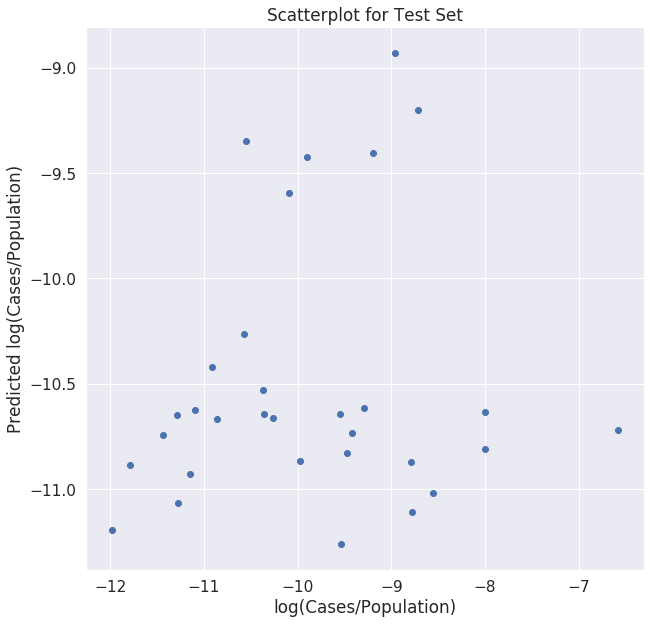

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.06034 +/- 0.02736
Feature:                        Avg. NO, Score: 0.27487 +/- 0.31099


<Figure size 432x288 with 0 Axes>

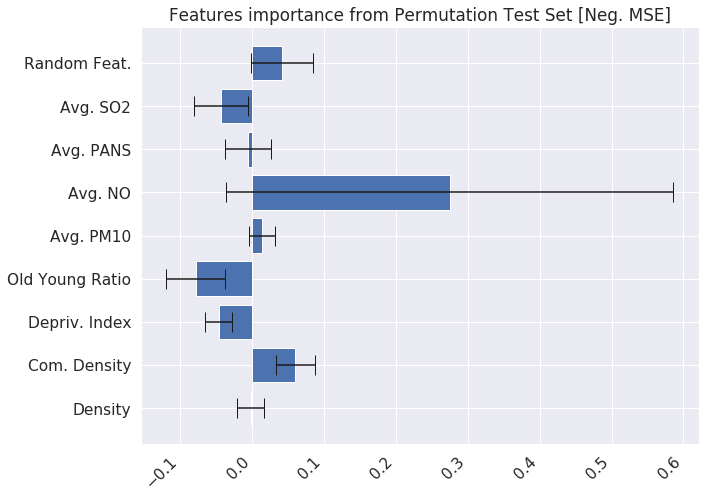

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.03996 +/- 0.01812
Feature:                        Avg. NO, Score: 0.18205 +/- 0.20597


<Figure size 432x288 with 0 Axes>

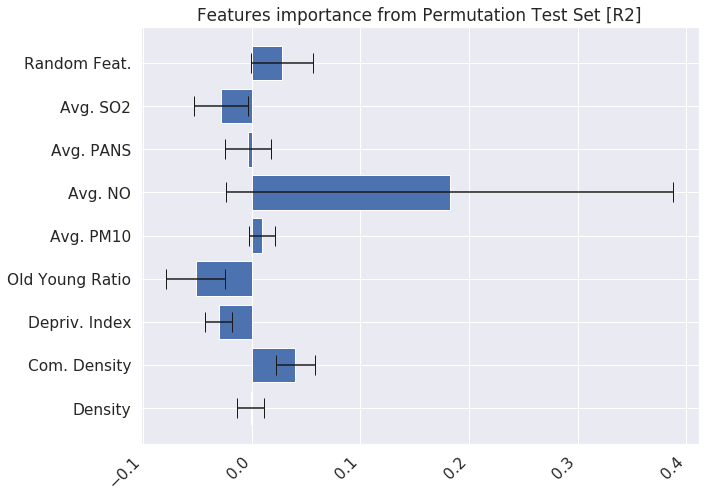

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                Old Young Ratio, Score: 0.07991 +/- 0.01738
Feature:                        Avg. NO, Score: 1.30054 +/- 0.27119
Feature:                       Avg. SO2, Score: 0.05667 +/- 0.01806


<Figure size 432x288 with 0 Axes>

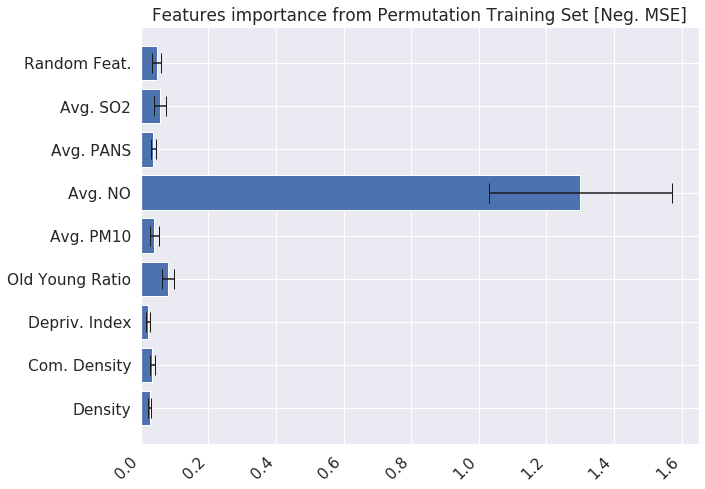

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                Old Young Ratio, Score: 0.07373 +/- 0.01604
Feature:                        Avg. NO, Score: 1.19991 +/- 0.25021
Feature:                       Avg. SO2, Score: 0.05228 +/- 0.01666


<Figure size 432x288 with 0 Axes>

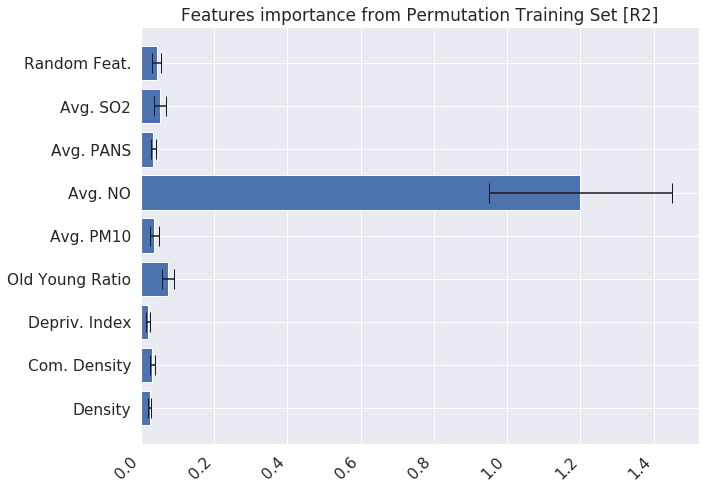

<Figure size 720x720 with 0 Axes>

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_traininingset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.36749  0.04453 
    Test set average RMSE:  0.99447  0.11677 

Prediction STD :    0.87829
True value STD :    1.15017
Difference in percentage:   23.63801

             Fullset RMSE:    0.35302
                       R2:    0.90579


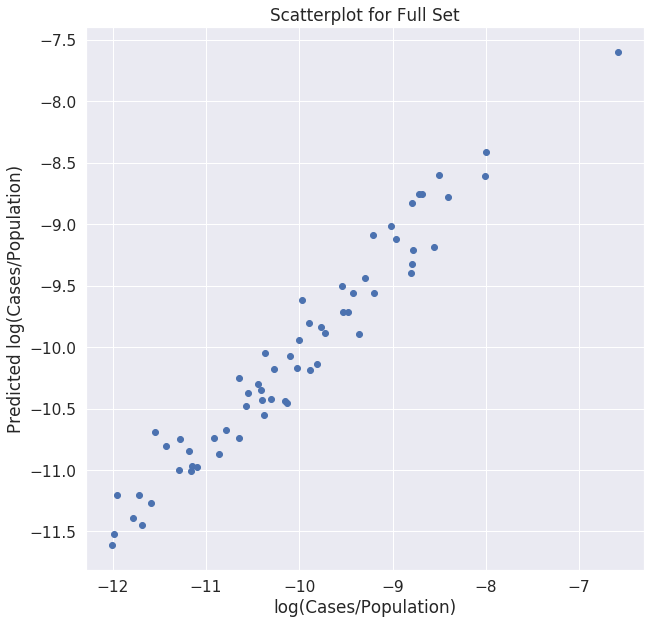

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.10406 +/- 0.01397
Feature:                  Depriv. Index, Score: 0.30039 +/- 0.05494
Feature:                Old Young Ratio, Score: 0.26169 +/- 0.03201
Feature:                      Avg. PM10, Score: 0.15530 +/- 0.02807
Feature:                        Avg. NO, Score: 0.25473 +/- 0.03813
Feature:                       Avg. SO2, Score: 0.09863 +/- 0.01575


<Figure size 432x288 with 0 Axes>

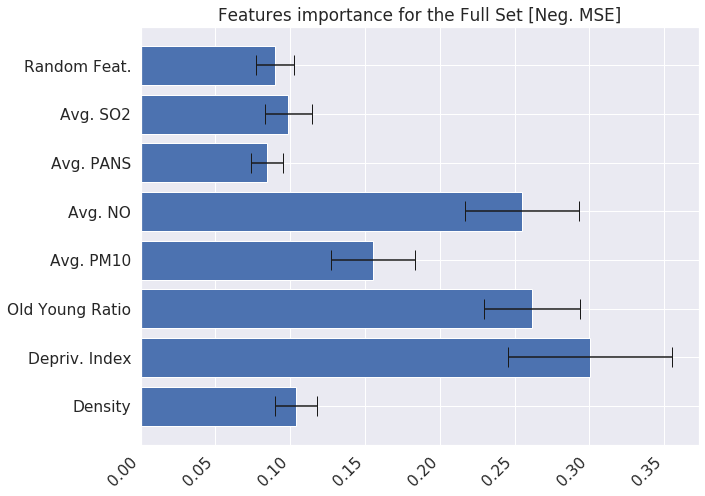

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.07866 +/- 0.01056
Feature:                  Depriv. Index, Score: 0.22707 +/- 0.04153
Feature:                Old Young Ratio, Score: 0.19781 +/- 0.02419
Feature:                      Avg. PM10, Score: 0.11739 +/- 0.02122
Feature:                        Avg. NO, Score: 0.19256 +/- 0.02882
Feature:                       Avg. SO2, Score: 0.07455 +/- 0.01190


<Figure size 432x288 with 0 Axes>

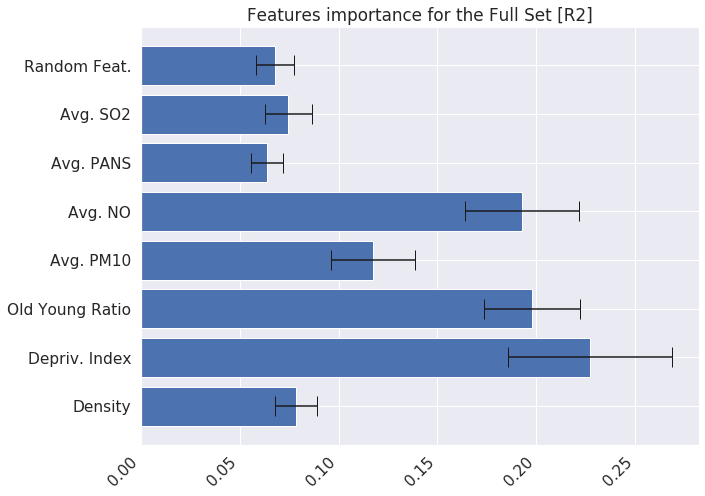

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.38540
                       R2:    0.90243


<Figure size 432x288 with 0 Axes>

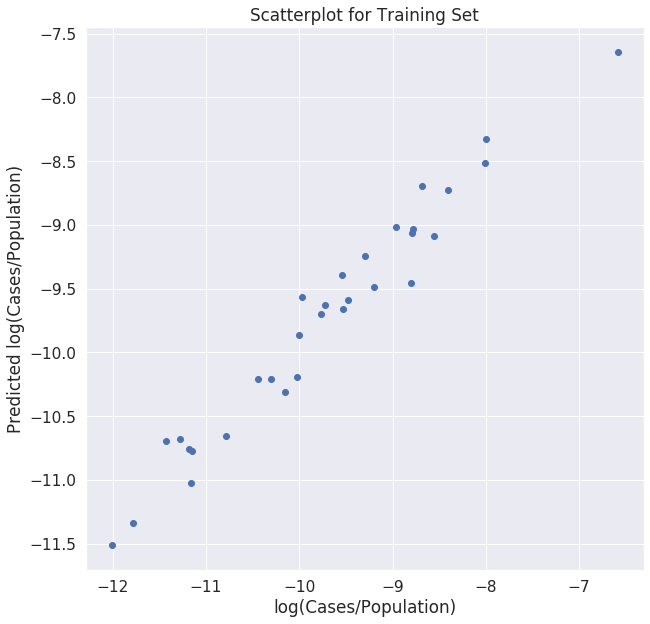

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.94384
                       R2:    0.02860


<Figure size 432x288 with 0 Axes>

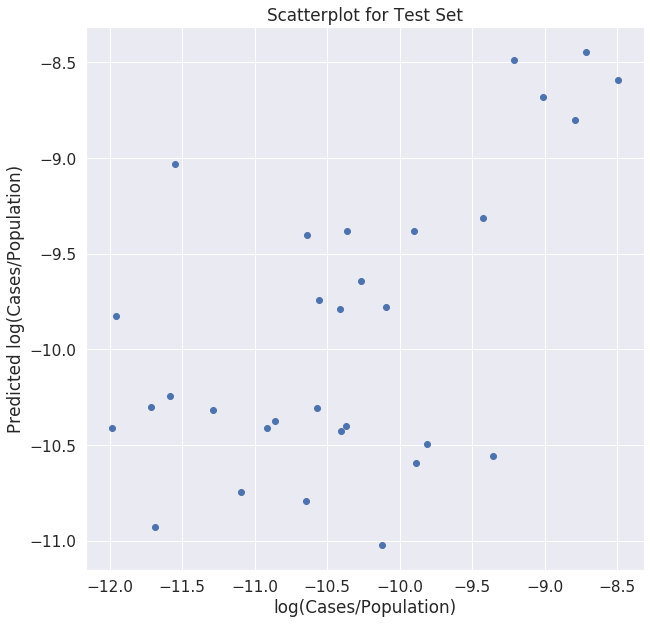

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.04659 +/- 0.04225
Feature:                  Depriv. Index, Score: 0.01362 +/- 0.05559
Feature:                Old Young Ratio, Score: 0.06705 +/- 0.07999
Feature:                      Avg. PM10, Score: 0.01725 +/- 0.05767
Feature:                        Avg. NO, Score: 0.07571 +/- 0.07395
Feature:                       Avg. SO2, Score: 0.04835 +/- 0.03106


<Figure size 432x288 with 0 Axes>

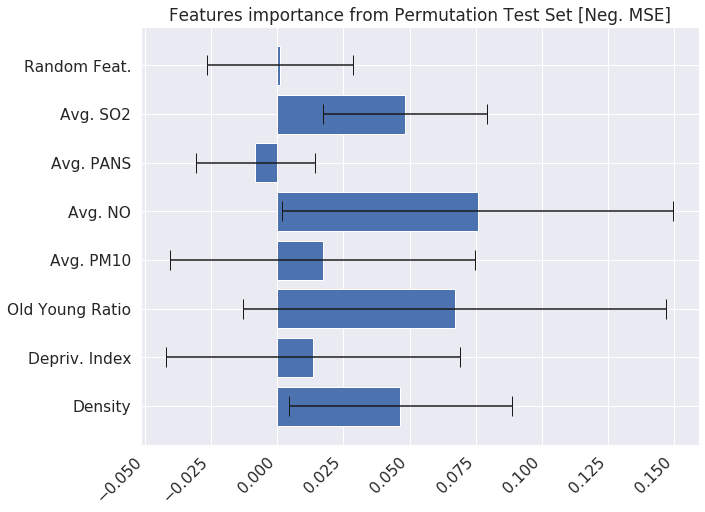

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.05081 +/- 0.04607
Feature:                  Depriv. Index, Score: 0.01485 +/- 0.06062
Feature:                Old Young Ratio, Score: 0.07311 +/- 0.08722
Feature:                      Avg. PM10, Score: 0.01881 +/- 0.06289
Feature:                        Avg. NO, Score: 0.08256 +/- 0.08064
Feature:                       Avg. SO2, Score: 0.05273 +/- 0.03387


<Figure size 432x288 with 0 Axes>

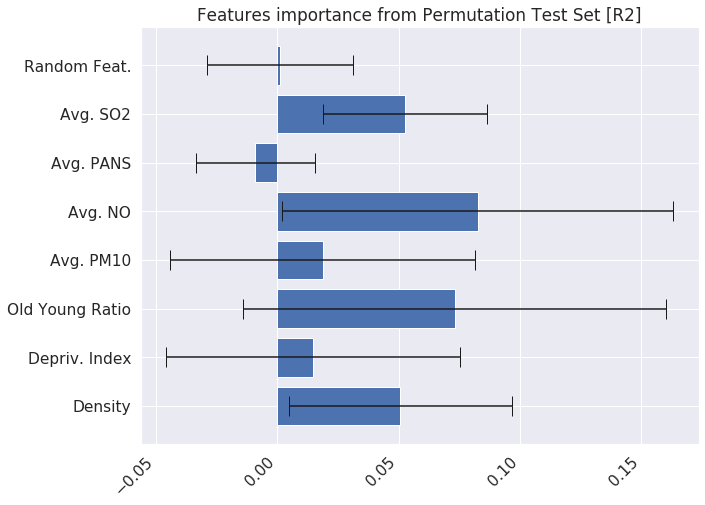

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.13270 +/- 0.02730
Feature:                  Depriv. Index, Score: 0.26022 +/- 0.06159
Feature:                Old Young Ratio, Score: 0.38552 +/- 0.08698
Feature:                      Avg. PM10, Score: 0.14969 +/- 0.03223
Feature:                        Avg. NO, Score: 0.20767 +/- 0.05357
Feature:                      Avg. PANS, Score: 0.09443 +/- 0.01732
Feature:                       Avg. SO2, Score: 0.10825 +/- 0.02504


<Figure size 432x288 with 0 Axes>

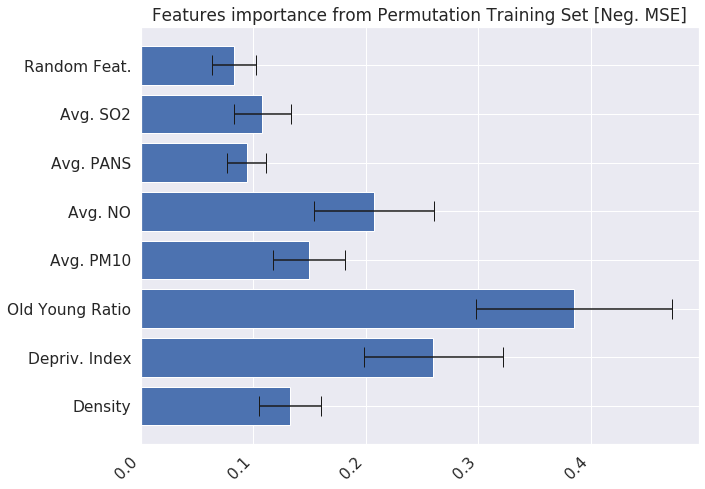

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.08717 +/- 0.01793
Feature:                  Depriv. Index, Score: 0.17094 +/- 0.04046
Feature:                Old Young Ratio, Score: 0.25325 +/- 0.05714
Feature:                      Avg. PM10, Score: 0.09833 +/- 0.02117
Feature:                        Avg. NO, Score: 0.13642 +/- 0.03519
Feature:                      Avg. PANS, Score: 0.06203 +/- 0.01138
Feature:                       Avg. SO2, Score: 0.07111 +/- 0.01645


<Figure size 432x288 with 0 Axes>

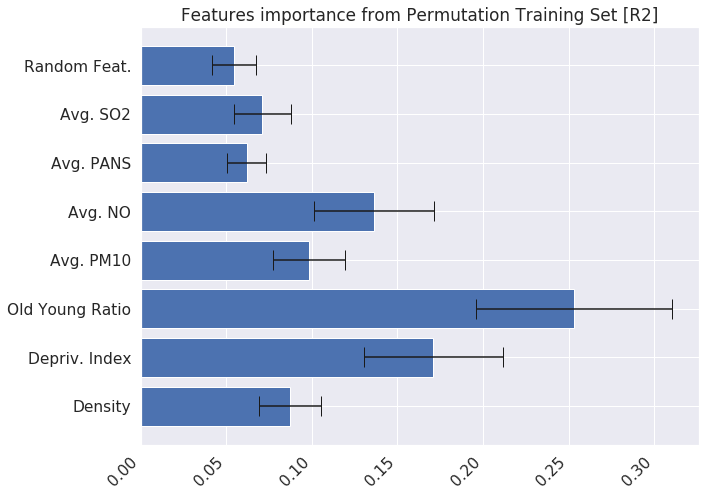

<Figure size 720x720 with 0 Axes>

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Test Set 

Starting ...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.68365  0.06968 
    Test set average RMSE:  0.86356  0.10234 

Prediction STD :    0.87257
True value STD :    1.15017
Difference in percentage:   24.13573

             Fullset RMSE:    0.63772
                       R2:    0.69258


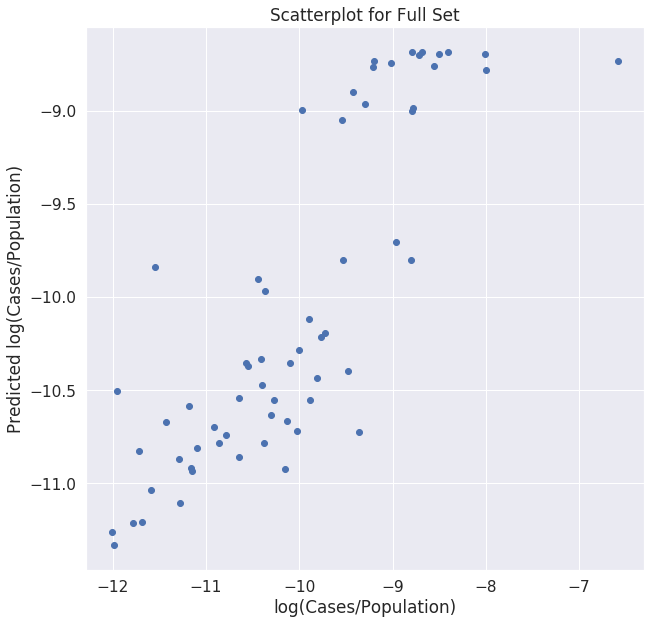

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                       Latitude, Score: 1.40302 +/- 0.20984


<Figure size 432x288 with 0 Axes>

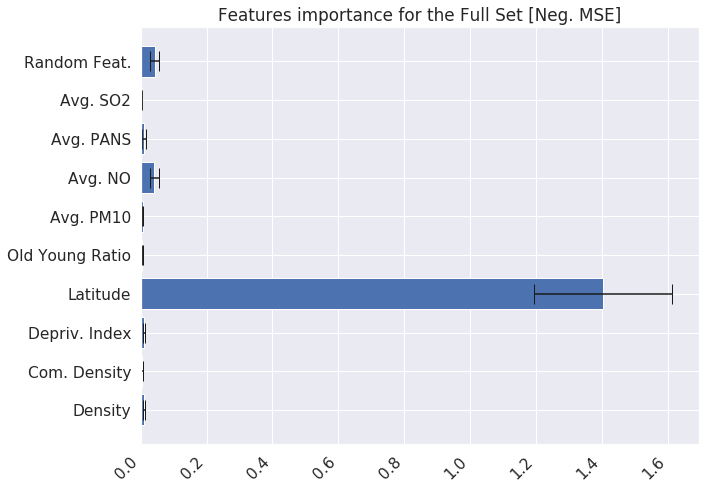

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                       Latitude, Score: 1.06057 +/- 0.15862


<Figure size 432x288 with 0 Axes>

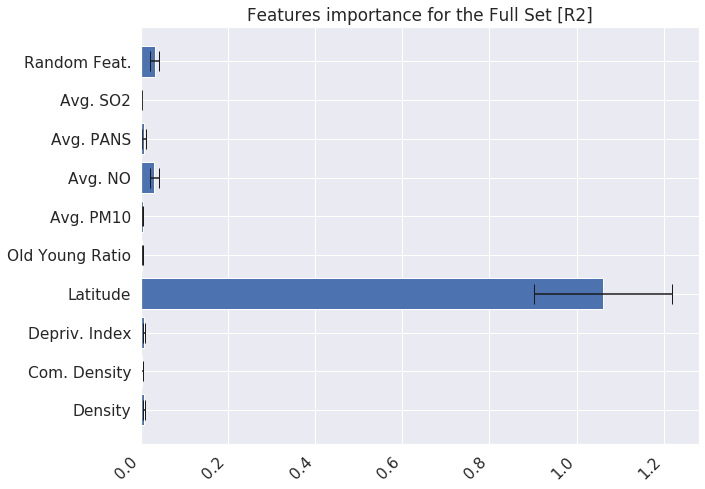

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.53692
                       R2:    0.65599


<Figure size 432x288 with 0 Axes>

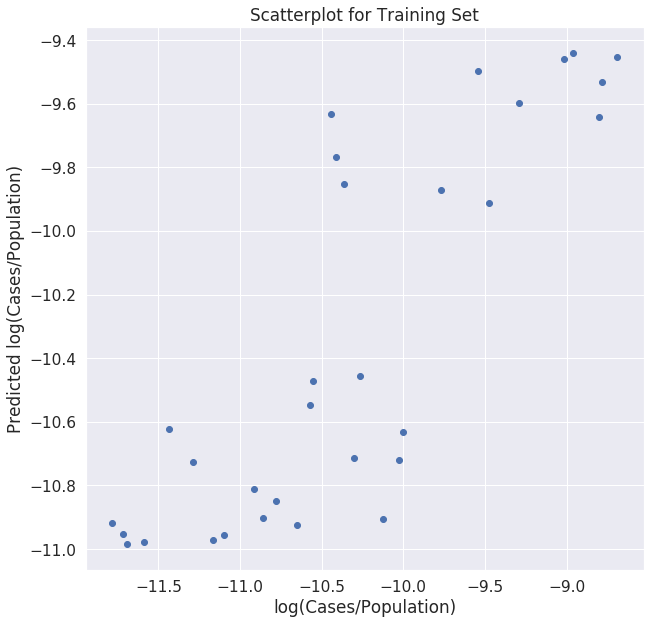

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.10085
                       R2:    0.26717


<Figure size 432x288 with 0 Axes>

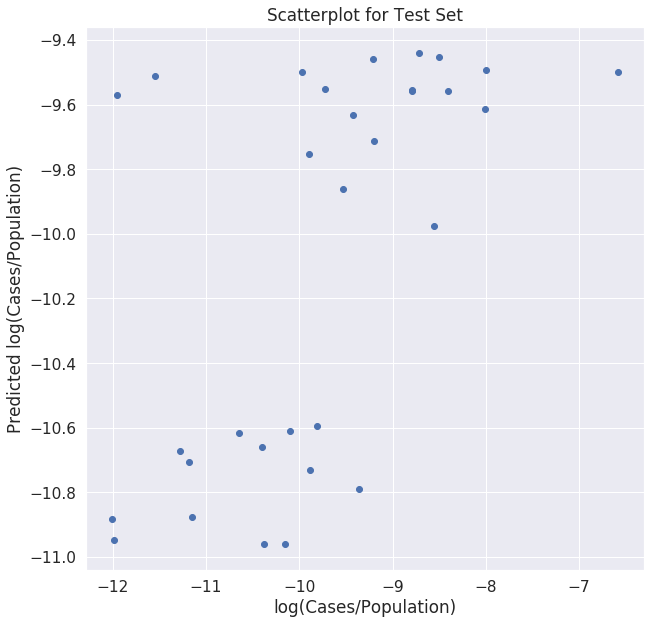

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.00037 +/- 0.00116
Feature:                   Com. Density, Score: 0.05466 +/- 0.05201
Feature:                  Depriv. Index, Score: 0.02146 +/- 0.03564
Feature:                       Latitude, Score: 0.42118 +/- 0.17388
Feature:                Old Young Ratio, Score: 0.00107 +/- 0.00555
Feature:                      Avg. PM10, Score: 0.00198 +/- 0.00262
Feature:                        Avg. NO, Score: 0.05106 +/- 0.03175


<Figure size 432x288 with 0 Axes>

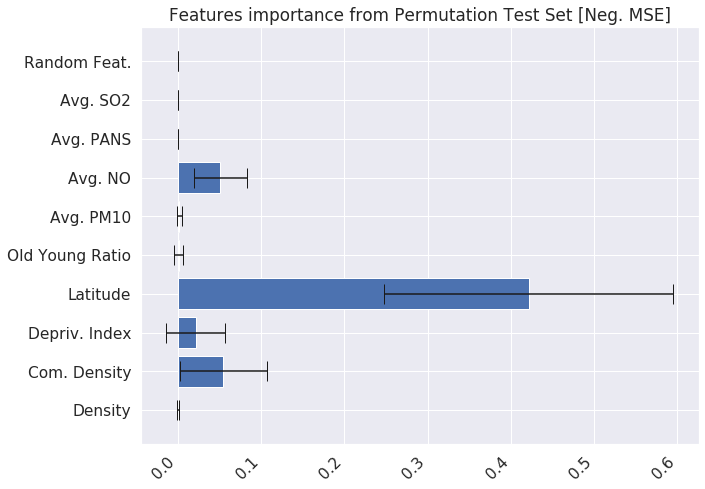

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.00022 +/- 0.00070
Feature:                   Com. Density, Score: 0.03305 +/- 0.03145
Feature:                  Depriv. Index, Score: 0.01297 +/- 0.02155
Feature:                       Latitude, Score: 0.25469 +/- 0.10515
Feature:                Old Young Ratio, Score: 0.00065 +/- 0.00336
Feature:                      Avg. PM10, Score: 0.00120 +/- 0.00159
Feature:                        Avg. NO, Score: 0.03087 +/- 0.01920


<Figure size 432x288 with 0 Axes>

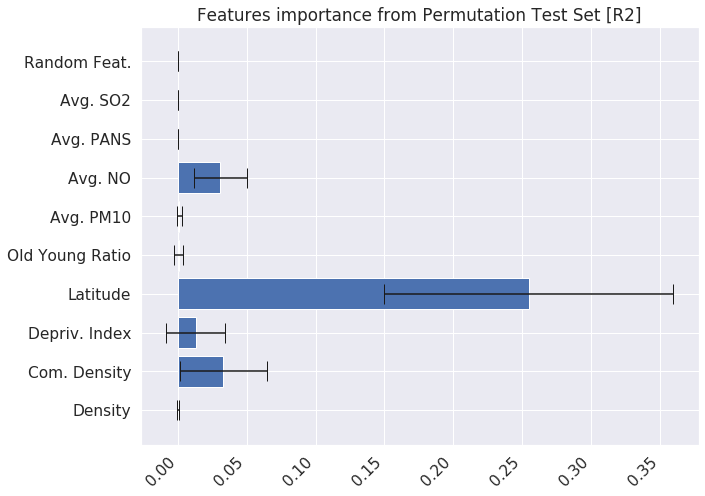

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.00189 +/- 0.00094
Feature:                   Com. Density, Score: 0.06947 +/- 0.02412
Feature:                  Depriv. Index, Score: 0.05139 +/- 0.01973
Feature:                       Latitude, Score: 0.33780 +/- 0.08415
Feature:                Old Young Ratio, Score: 0.00347 +/- 0.00224
Feature:                      Avg. PM10, Score: 0.00122 +/- 0.00133
Feature:                        Avg. NO, Score: 0.05592 +/- 0.01770


<Figure size 432x288 with 0 Axes>

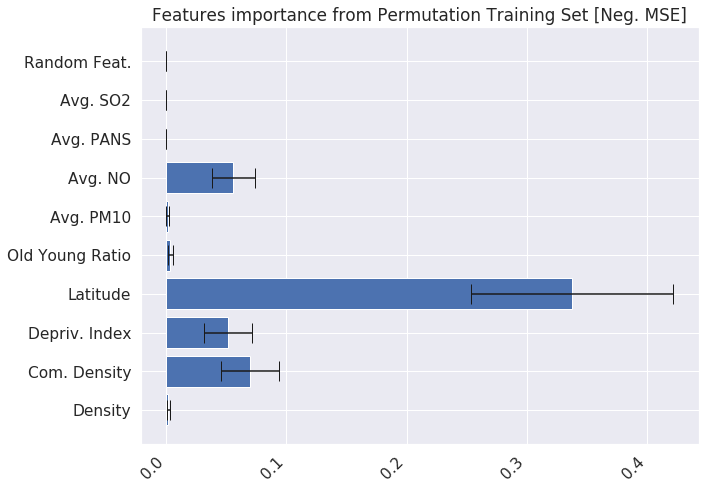

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.00225 +/- 0.00113
Feature:                   Com. Density, Score: 0.08289 +/- 0.02878
Feature:                  Depriv. Index, Score: 0.06132 +/- 0.02355
Feature:                       Latitude, Score: 0.40309 +/- 0.10042
Feature:                Old Young Ratio, Score: 0.00415 +/- 0.00267
Feature:                      Avg. PM10, Score: 0.00146 +/- 0.00158
Feature:                        Avg. NO, Score: 0.06673 +/- 0.02113


<Figure size 432x288 with 0 Axes>

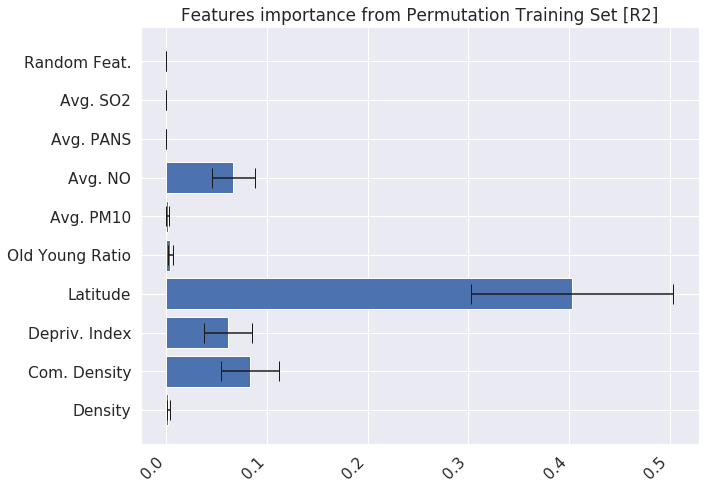

<Figure size 720x720 with 0 Axes>

In [14]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Starting ...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.49220  0.05745 
    Test set average RMSE:  0.96435  0.09381 

Prediction STD :    0.82801
True value STD :    1.15017
Difference in percentage:   28.01022

             Fullset RMSE:    0.47783
                       R2:    0.82741


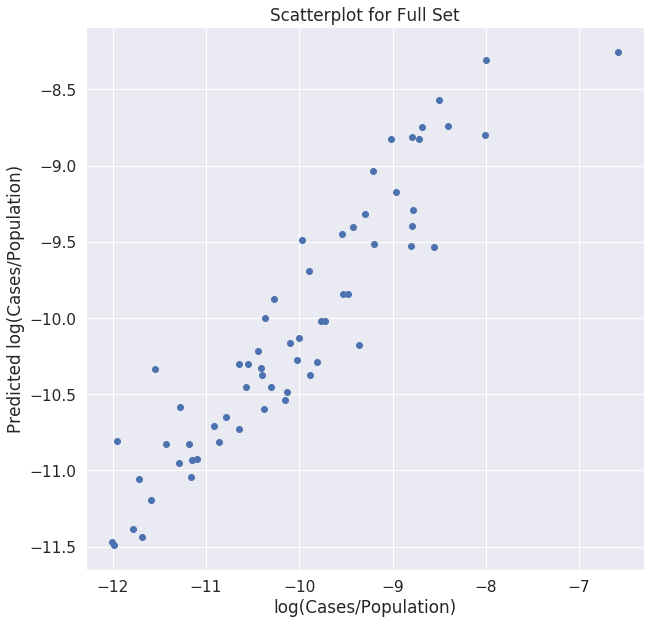

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.28392 +/- 0.05433
Feature:                  Depriv. Index, Score: 0.17138 +/- 0.03581
Feature:                Old Young Ratio, Score: 0.17679 +/- 0.02427
Feature:                      Avg. PM10, Score: 0.09615 +/- 0.01866
Feature:                        Avg. NO, Score: 0.19366 +/- 0.03509
Feature:                       Avg. SO2, Score: 0.07742 +/- 0.01649


<Figure size 432x288 with 0 Axes>

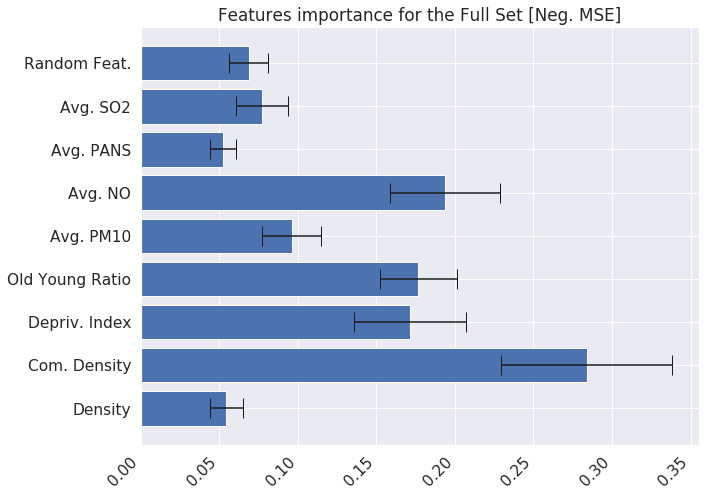

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                   Com. Density, Score: 0.21462 +/- 0.04107
Feature:                  Depriv. Index, Score: 0.12955 +/- 0.02707
Feature:                Old Young Ratio, Score: 0.13364 +/- 0.01835
Feature:                      Avg. PM10, Score: 0.07268 +/- 0.01411
Feature:                        Avg. NO, Score: 0.14639 +/- 0.02653
Feature:                       Avg. SO2, Score: 0.05852 +/- 0.01246


<Figure size 432x288 with 0 Axes>

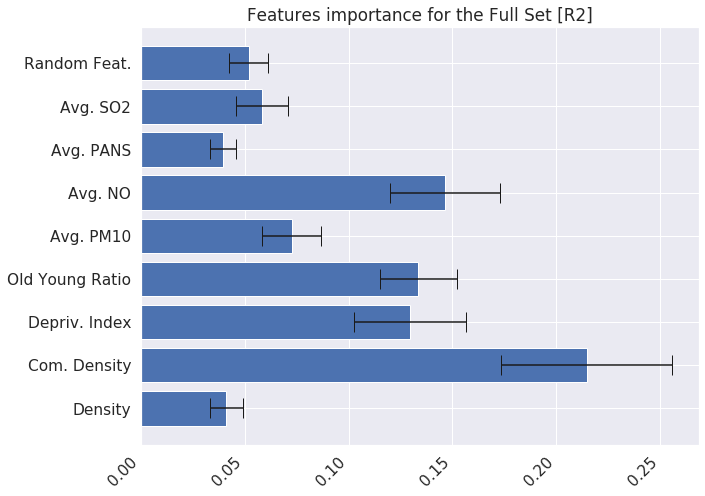

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.42686
                       R2:    0.78409


<Figure size 432x288 with 0 Axes>

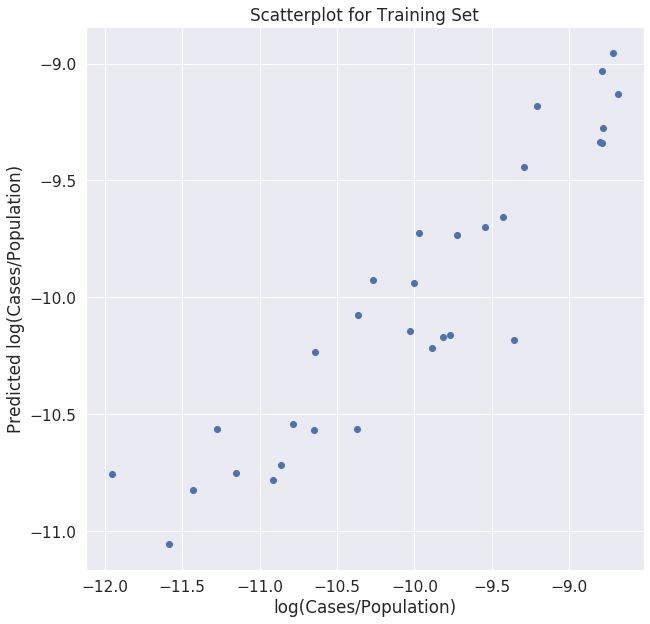

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.10200
                       R2:    0.32539


<Figure size 432x288 with 0 Axes>

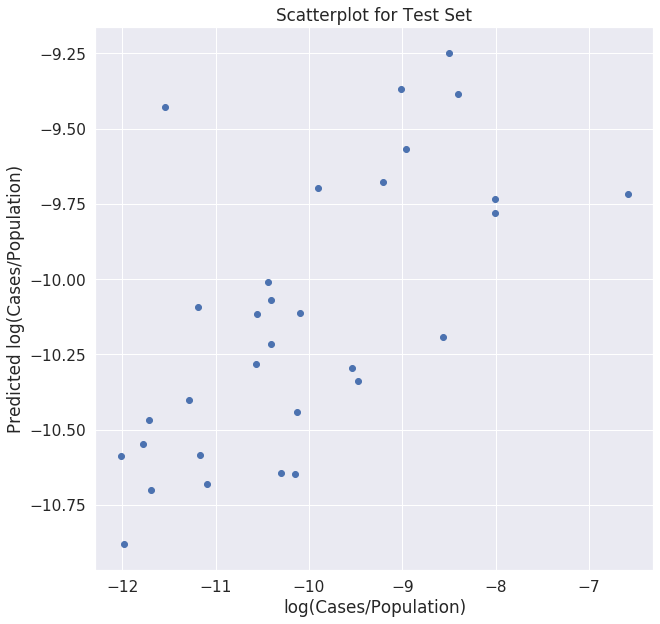

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.00026 +/- 0.02020
Feature:                   Com. Density, Score: 0.25203 +/- 0.07972
Feature:                  Depriv. Index, Score: 0.15289 +/- 0.06396
Feature:                Old Young Ratio, Score: 0.06363 +/- 0.03975
Feature:                      Avg. PM10, Score: 0.01659 +/- 0.00725
Feature:                        Avg. NO, Score: 0.16395 +/- 0.07334
Feature:                       Avg. SO2, Score: 0.01630 +/- 0.01621


<Figure size 432x288 with 0 Axes>

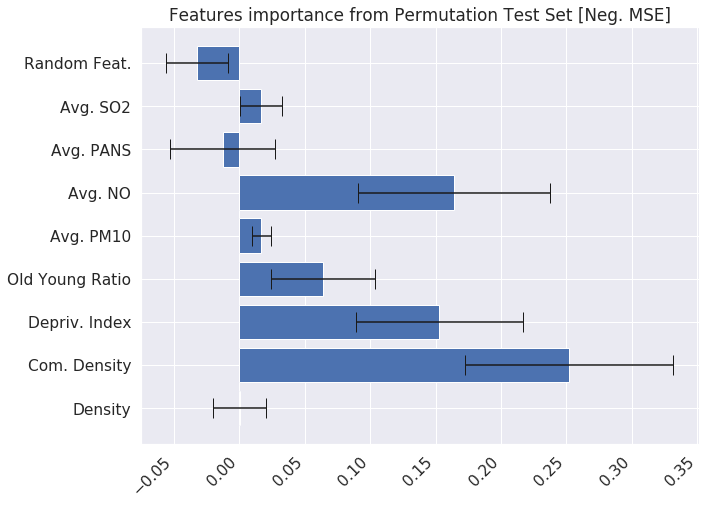

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.00014 +/- 0.01122
Feature:                   Com. Density, Score: 0.14001 +/- 0.04428
Feature:                  Depriv. Index, Score: 0.08493 +/- 0.03553
Feature:                Old Young Ratio, Score: 0.03535 +/- 0.02208
Feature:                      Avg. PM10, Score: 0.00922 +/- 0.00403
Feature:                        Avg. NO, Score: 0.09108 +/- 0.04074
Feature:                       Avg. SO2, Score: 0.00906 +/- 0.00901


<Figure size 432x288 with 0 Axes>

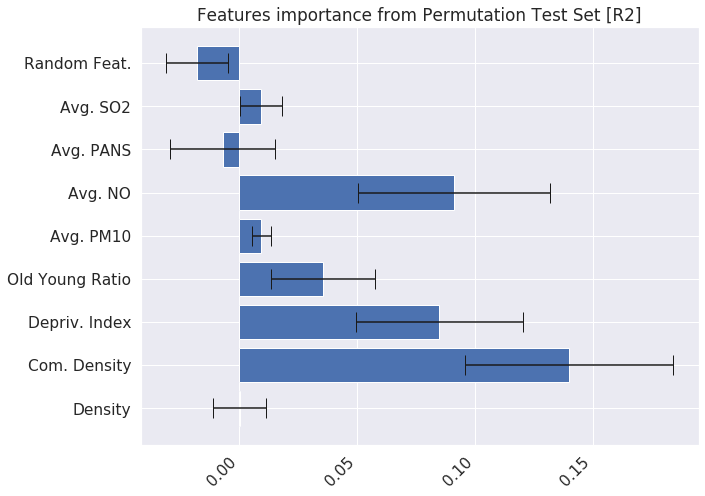

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.04541 +/- 0.01494
Feature:                   Com. Density, Score: 0.18637 +/- 0.04955
Feature:                  Depriv. Index, Score: 0.08123 +/- 0.02029
Feature:                Old Young Ratio, Score: 0.05588 +/- 0.01216
Feature:                        Avg. NO, Score: 0.15857 +/- 0.03709
Feature:                      Avg. PANS, Score: 0.07980 +/- 0.02124
Feature:                       Avg. SO2, Score: 0.04080 +/- 0.00966


<Figure size 432x288 with 0 Axes>

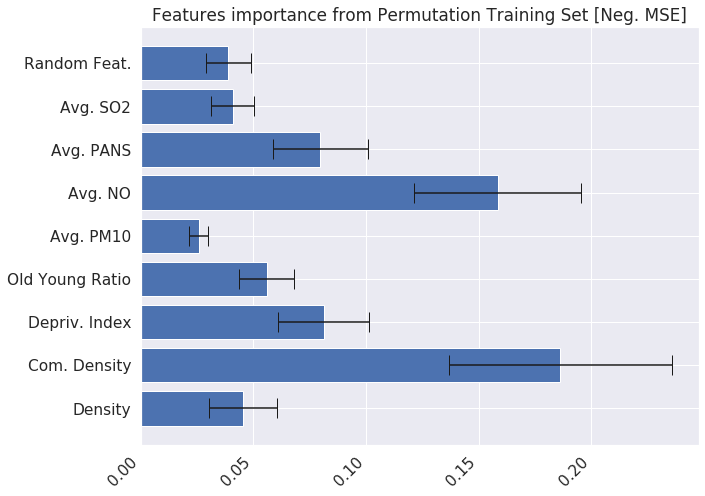

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.05381 +/- 0.01770
Feature:                   Com. Density, Score: 0.22084 +/- 0.05871
Feature:                  Depriv. Index, Score: 0.09626 +/- 0.02405
Feature:                Old Young Ratio, Score: 0.06621 +/- 0.01441
Feature:                        Avg. NO, Score: 0.18791 +/- 0.04395
Feature:                      Avg. PANS, Score: 0.09456 +/- 0.02517
Feature:                       Avg. SO2, Score: 0.04835 +/- 0.01145


<Figure size 432x288 with 0 Axes>

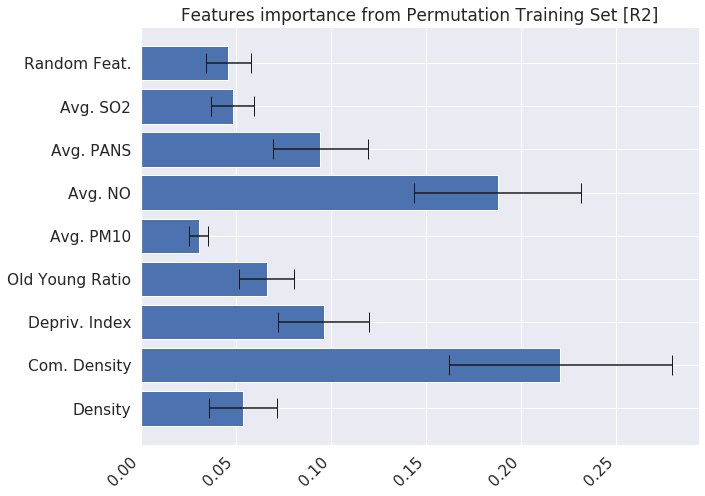

<Figure size 720x720 with 0 Axes>

In [15]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_testset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Starting ...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.71353  0.08237 
    Test set average RMSE:  1.03594  0.10972 

Prediction STD :    0.76289
True value STD :    1.15017
Difference in percentage:   33.67187

             Fullset RMSE:    0.67643
                       R2:    0.65412


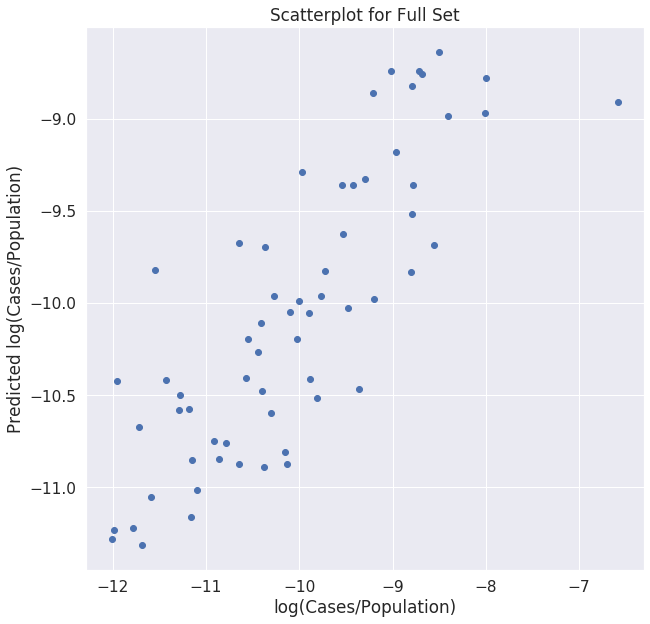

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.04731 +/- 0.01225
Feature:                  Depriv. Index, Score: 0.32683 +/- 0.07301
Feature:                Old Young Ratio, Score: 0.18734 +/- 0.03774
Feature:                        Avg. NO, Score: 0.27655 +/- 0.05791
Feature:                       Avg. SO2, Score: 0.09474 +/- 0.03128


<Figure size 432x288 with 0 Axes>

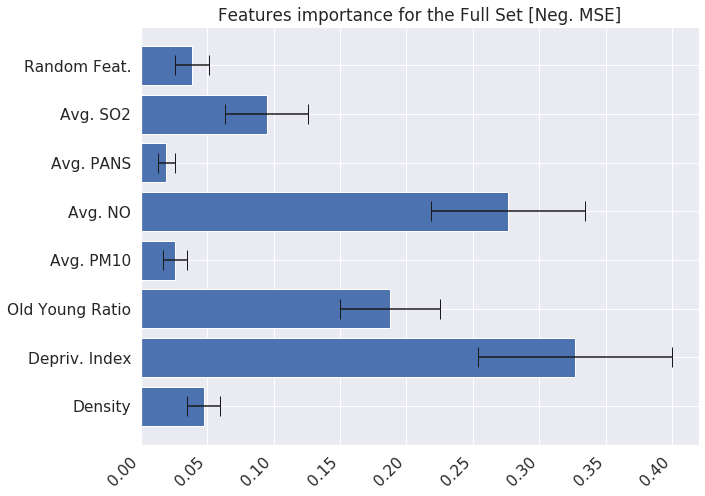

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.03577 +/- 0.00926
Feature:                  Depriv. Index, Score: 0.24705 +/- 0.05519
Feature:                Old Young Ratio, Score: 0.14162 +/- 0.02853
Feature:                        Avg. NO, Score: 0.20905 +/- 0.04378
Feature:                       Avg. SO2, Score: 0.07162 +/- 0.02365


<Figure size 432x288 with 0 Axes>

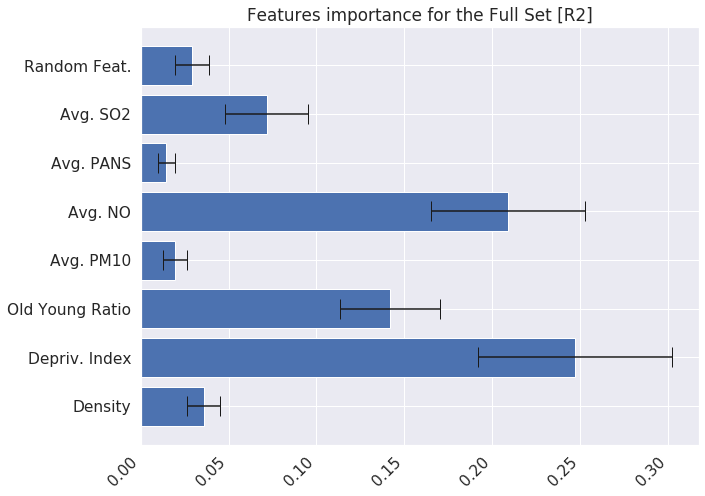

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.79298
                       R2:    0.54043


<Figure size 432x288 with 0 Axes>

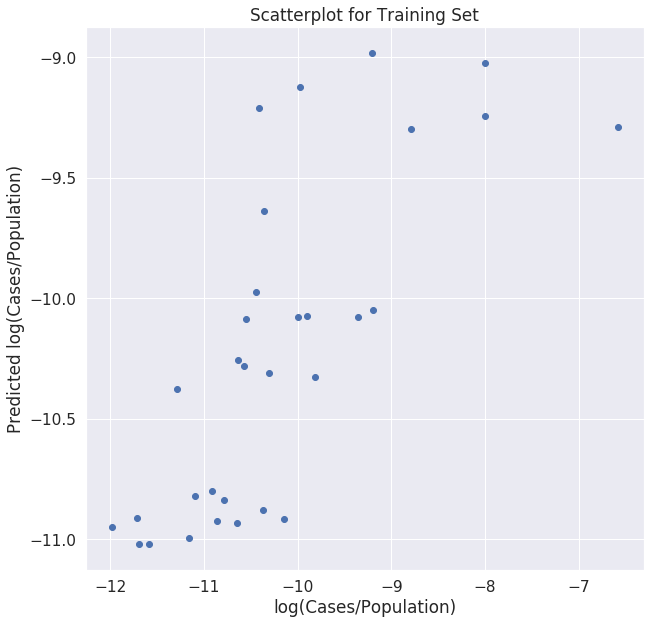

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.99703
                       R2:    0.19374


<Figure size 432x288 with 0 Axes>

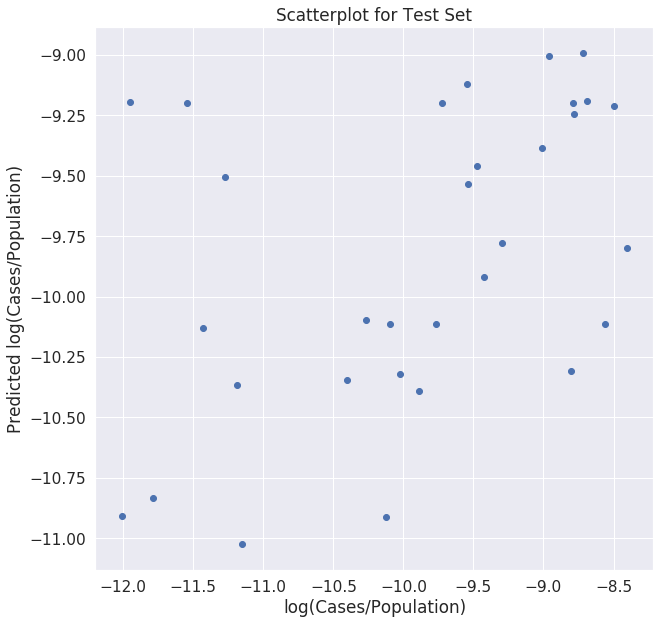

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.21533 +/- 0.15577
Feature:                Old Young Ratio, Score: 0.04840 +/- 0.05521
Feature:                      Avg. PM10, Score: 0.02513 +/- 0.02360
Feature:                        Avg. NO, Score: 0.15332 +/- 0.06423


<Figure size 432x288 with 0 Axes>

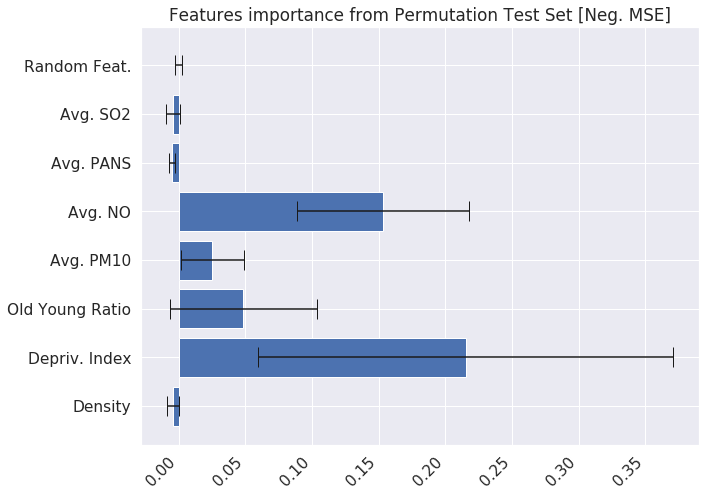

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.17465 +/- 0.12634
Feature:                Old Young Ratio, Score: 0.03926 +/- 0.04478
Feature:                      Avg. PM10, Score: 0.02038 +/- 0.01914
Feature:                        Avg. NO, Score: 0.12435 +/- 0.05210


<Figure size 432x288 with 0 Axes>

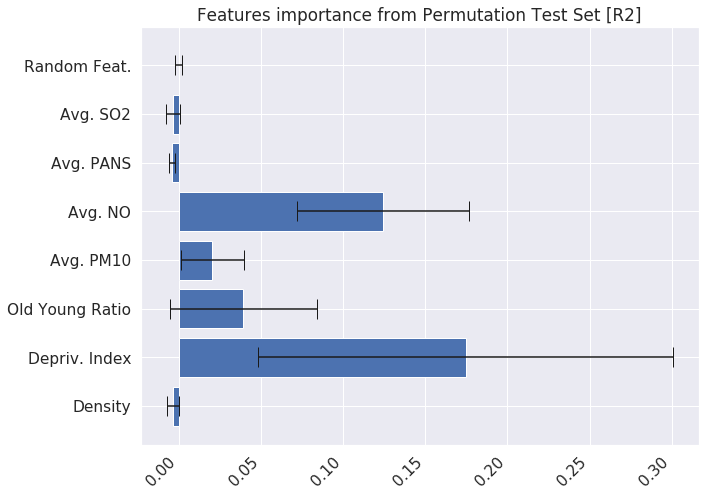

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.00807 +/- 0.00330
Feature:                  Depriv. Index, Score: 0.44395 +/- 0.12996
Feature:                Old Young Ratio, Score: 0.04848 +/- 0.04367
Feature:                      Avg. PM10, Score: 0.05958 +/- 0.02584
Feature:                        Avg. NO, Score: 0.17111 +/- 0.07146
Feature:                      Avg. PANS, Score: 0.00478 +/- 0.00243
Feature:                       Avg. SO2, Score: 0.00325 +/- 0.00506


<Figure size 432x288 with 0 Axes>

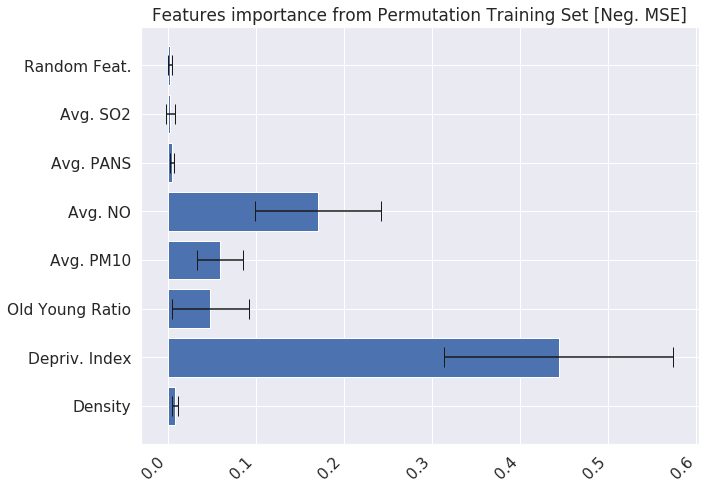

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.00590 +/- 0.00241
Feature:                  Depriv. Index, Score: 0.32446 +/- 0.09498
Feature:                Old Young Ratio, Score: 0.03543 +/- 0.03192
Feature:                      Avg. PM10, Score: 0.04354 +/- 0.01888
Feature:                        Avg. NO, Score: 0.12505 +/- 0.05223
Feature:                      Avg. PANS, Score: 0.00349 +/- 0.00178
Feature:                       Avg. SO2, Score: 0.00238 +/- 0.00370


<Figure size 432x288 with 0 Axes>

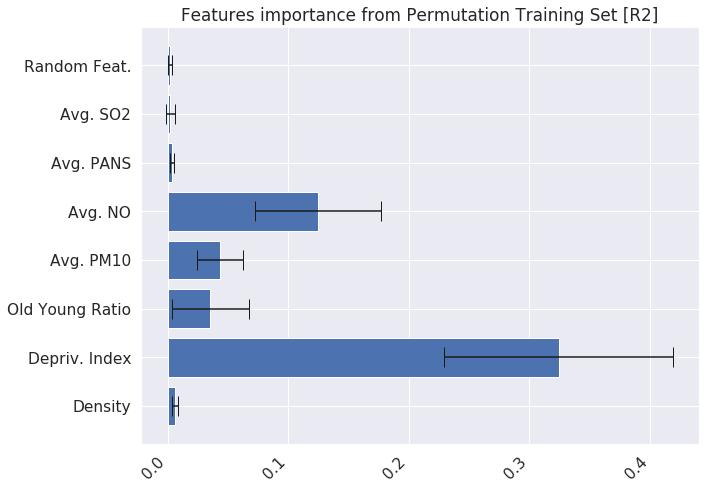

<Figure size 720x720 with 0 Axes>

In [16]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Using mutiple split test and training 

In [17]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800,
 'random_state': 1}


In [18]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=100, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.32544 +/-  0.04315 
    Test set average RMSE:  0.87813 +/-  0.09598 
  Training set average R2:  0.91835 +/-  0.01821 
      Test set average R2:  0.38150 +/-  0.13121 
Taining:
             Density ,    0.04395 +/-    0.03246 ,   -0.00867 +/-    0.01771 ,    0.00000 ,   11.00000 ,    0.00000 ,    3.00000
        Com. Density ,    0.05371 +/-    0.05878 ,   -0.00993 +/-    0.02544 ,    0.00000 ,   14.00000 ,    0.00000 ,    6.00000
       Depriv. Index ,    0.05099 +/-    0.04685 ,   -0.00309 +/-    0.02410 ,    0.00000 ,   17.00000 ,    0.00000 ,    9.00000
            Latitude ,    1.24177 +/-    0.45575 ,    0.76806 +/-    0.28717 ,  100.00000 ,    0.00000 ,  100.00000 ,    0.00000
     Old Young Ratio ,    0.04637 +/-    0.03621 ,   -0.00624 +/-    0.01791 ,    0.00000 ,   11.00000 ,    0.00000 ,    6.00000
           Avg. PM10 ,    0.04250 +/-    0.02898 ,   -0

<Figure size 720x720 with 0 Axes>

In [19]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 1}


In [20]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=100, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.34880 +/-  0.05084 
    Test set average RMSE:  0.96377 +/-  0.11082 
  Training set average R2:  0.90539 +/-  0.02149 
      Test set average R2:  0.26189 +/-  0.14235 
Taining:
             Density ,    0.06784 +/-    0.04071 ,    0.00584 +/-    0.02442 ,    1.00000 ,    1.00000 ,    0.00000 ,    3.00000
        Com. Density ,    0.27095 +/-    0.09532 ,    0.13386 +/-    0.05946 ,   58.00000 ,   25.00000 ,   79.00000 ,   11.00000
       Depriv. Index ,    0.19387 +/-    0.09260 ,    0.05673 +/-    0.05551 ,   15.00000 ,   31.00000 ,    7.00000 ,   22.00000
     Old Young Ratio ,    0.16677 +/-    0.07204 ,    0.04886 +/-    0.04731 ,   11.00000 ,   23.00000 ,    3.00000 ,   21.00000
           Avg. PM10 ,    0.10259 +/-    0.06418 ,    0.01375 +/-    0.03603 ,    2.00000 ,    5.00000 ,    2.00000 ,    7.00000
             Avg. NO ,    0.14793 +/-    0.06895 ,    0

<Figure size 720x720 with 0 Axes>

In [21]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1200,
 'random_state': 1}


In [22]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=100, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.35993 +/-  0.03734 
    Test set average RMSE:  0.99965 +/-  0.10311 
  Training set average R2:  0.89972 +/-  0.01643 
      Test set average R2:  0.21619 +/-  0.12069 
Taining:
             Density ,    0.09762 +/-    0.03559 ,    0.00805 +/-    0.02782 ,    0.00000 ,    1.00000 ,    0.00000 ,    1.00000
       Depriv. Index ,    0.23552 +/-    0.09098 ,    0.10372 +/-    0.04543 ,   32.00000 ,   35.00000 ,   43.00000 ,   29.00000
     Old Young Ratio ,    0.22382 +/-    0.08252 ,    0.07964 +/-    0.03942 ,   29.00000 ,   32.00000 ,   15.00000 ,   33.00000
           Avg. PM10 ,    0.14642 +/-    0.07095 ,    0.02379 +/-    0.03842 ,    4.00000 ,   11.00000 ,    2.00000 ,    3.00000
             Avg. NO ,    0.22561 +/-    0.08480 ,    0.09624 +/-    0.04484 ,   34.00000 ,   19.00000 ,   40.00000 ,   33.00000
           Avg. PANS ,    0.08319 +/-    0.03233 ,   -0

<Figure size 720x720 with 0 Axes>